# Taller práctico: Introducción al Federated Learning con Flower
**Duración:** 3 horas &nbsp;&nbsp;|&nbsp;&nbsp; **Última actualización:** 2025-08-26 08:33 UTC

Este cuaderno guía paso a paso un taller intensivo de *Federated Learning* (FL) con **Flower**. Incluye:
- Preparación del entorno y comprobación de versiones
- Recordatorio conceptual de FL y arquitectura de Flower
- Experimentos **centralizados** y **federados** sobre dos dominios: un dataset tabular de **ciberseguridad** (KDDCup99 10%) y un dataset de **visión** (MNIST)
- Varias **estrategias** (FedAvg, FedAdam y FedProx personalizado)
- Particiones **IID** y **no-IID** (Dirichlet) y análisis de su impacto
- Comparación de métricas y trazado de curvas de rendimiento
- Extensiones opcionales: robustez, *stragglers*, privacidad diferencial (Opacus), *early stopping*

> **Objetivos de aprendizaje**
>
> 1. Comprender los principios de FL y la interfaz de Flower (clientes/servidor/estrategias).
> 2. Implementar un flujo de trabajo reproducible de experimentación.
> 3. Evaluar y comparar entrenamiento centralizado vs. federado bajo distintos supuestos.
> 4. Analizar los efectos de la heterogeneidad de datos y de la estrategia de agregación.


## Índice
1. [Requisitos y preparación del entorno](#requisitos)
2. [Conceptos básicos de FL y arquitectura de Flower](#conceptos)
3. [Datasets y preprocesado](#datos)
    1. [KDDCup99 (10%) — Ciberseguridad](#kdd)
    2. [MNIST — Visión por computador](#mnist)
4. [Entrenamiento centralizado (baselines)](#centralizado)
5. [Simulación federada con Flower (tabular: KDD)](#fl_tabular)
    1. [Estrategias: FedAvg vs FedAdam vs FedProx](#estrategias)
    2. [Particionado IID vs No-IID (Dirichlet)](#dirichlet)
    3. [Métricas por ronda y comparación con el baseline](#metricas_tabular)
6. [Simulación federada con Flower (imagen: MNIST, CNN simple)](#fl_mnist)
7. [Experimentos avanzados (opcional): *stragglers*, robustez, privacidad diferencial](#avanzado)
8. [Ejercicios guiados y retos](#ejercicios)
9. [Buenas prácticas, reproducibilidad y referencias](#buenas_practicas)


<a id="requisitos"></a>
## 1. Requisitos y preparación del entorno

Ejecute esta celda para instalar dependencias mínimas. En entornos con **conda** se recomienda usar `environment.yml` incluido con este taller.

> **Nota:** Para simulaciones locales con muchos clientes utilice `flwr[simulation]`. En máquinas con GPU, instale la variante adecuada de PyTorch desde su gestor oficial.



In [1]:
# !pip -q install -U pip
# !pip -q install -U flwr[simulation] scikit-learn pandas numpy matplotlib torch torchvision torchaudio
# Opcionales (para secciones avanzadas):
# !pip -q install opacus

import sys, platform, numpy as np, pandas as pd, sklearn, matplotlib, torch, torchvision, flwr as fl
import matplotlib.pyplot as plt
print("Python:", sys.version.split()[0])
print("OS:", platform.platform())
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("Matplotlib:", matplotlib.__version__)
print("PyTorch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("Flower:", fl.__version__)


2025-08-28 14:42:02,238	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Python: 3.11.5
OS: Linux-6.14.0-24-generic-x86_64-with-glibc2.39
NumPy: 2.3.2
Pandas: 2.3.2
scikit-learn: 1.7.1
Matplotlib: 3.10.5
PyTorch: 2.8.0+cu128
Torchvision: 0.23.0+cu128
Flower: 1.20.0


<a id="conceptos"></a>
## 2. Conceptos básicos de FL y arquitectura de Flower

En **Federated Learning**, múltiples **clientes** (nodos) entrenan localmente sobre sus datos y comparten únicamente **actualizaciones de parámetros** con un **servidor** que las **agrega** siguiendo una **estrategia** (por ejemplo, *FedAvg*). Flower ofrece:

- Una API de **cliente** (`NumPyClient` o cliente PyTorch personalizado) con `get_parameters`, `fit` y `evaluate`.
- Un **servidor** que orquesta rondas y aplica la **estrategia** de agregación.
- Un módulo de **simulación** para ejecutar miles de clientes virtuales en una sola máquina.

**Estrategias**
- **FedAvg**: promedio ponderado por tamaño de datos.
- **FedAdam / FedYogi**: optimizadores a nivel de servidor que pueden acelerar la convergencia.
- **FedProx**: añade un término proximal en el entrenamiento local para mitigar la heterogeneidad (lo implementaremos de forma sencilla en el cliente).



<a id="datos"></a>
## 3. Datasets y preprocesado

Usaremos dos problemas estándar para ilustrar distintos *pipelines*:

- **KDDCup99 10% (Ciberseguridad)**: detección de intrusiones en red (tabular, multiclase altamente desbalanceada). Lo obtendremos desde **OpenML** con `fetch_openml`.
- **MNIST**: dígitos manuscritos (imagen).

> Si su entorno **no tiene Internet**, coloque los ficheros CSV/IDX previamente en `./data/` y active los *fallbacks* previstos.


<a id="kdd"></a>
### 3.1 KDDCup99 (10%) — Ciberseguridad

- **Tarea**: clasificación multiclase (normal vs varios tipos de ataque).
- **Preprocesado**: *one-hot* de variables categóricas (`protocol_type`, `service`, `flag`), escalado robusto de numéricas, submuestreo controlado para equilibrar.
- **Métrica principal**: macro-F1 y ROC-AUC *one-vs-rest*.



Descargamos **KDDCup99 10%** desde OpenML (o CSV local si existe).  
La columna objetivo se normaliza como `class`.


In [2]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd, numpy as np, os

def load_kddcup99_10(local_fallback_path='./data/kddcup99_10.csv'):
    try:
        print("Descargando KDDCup99 (10%) desde OpenML...")
        bunch = fetch_openml(name='KDDCup99', version=1, as_frame=True)
        df = bunch.frame.copy()
    except Exception as e:
        print("Fallo al descargar desde OpenML:", e)
        if os.path.exists(local_fallback_path):
            print("Usando copia local:", local_fallback_path)
            df = pd.read_csv(local_fallback_path)
        else:
            raise RuntimeError("No se pudo obtener KDDCup99 (10%).")
    if 'class' not in df.columns:
        df = df.rename(columns={df.columns[-1]: 'class'})
    df['class'] = df['class'].astype(str)
    print("Filas:", len(df), "Columnas:", len(df.columns))
    return df

df_kdd = load_kddcup99_10()
print(df_kdd.head())

Descargando KDDCup99 (10%) desde OpenML...
Filas: 494020 Columnas: 42
   duration protocol_type service flag  src_bytes  dst_bytes land  \
0         0           tcp    http   SF        181       5450    0   
1         0           tcp    http   SF        239        486    0   
2         0           tcp    http   SF        235       1337    0   
3         0           tcp    http   SF        219       1337    0   
4         0           tcp    http   SF        217       2032    0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                   9   
1               0       0    0  ...                  19   
2               0       0    0  ...                  29   
3               0       0    0  ...                  39   
4               0       0    0  ...                  49   

  dst_host_same_srv_rate  dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    1.0                     0.0                         0.11  

Inspeccionamos la estructura: tipos de variables, número de clases,  
y distribución de las 15 más frecuentes.

In [3]:
print(df_kdd.info())

# Conteo completo de todas las clases
class_counts = df_kdd['class'].value_counts()
print("Distribución de clases:")
print(class_counts)

# Gráfico de barras con todas las clases (puede ser muy largo)
plt.figure(figsize=(12,6))
class_counts.plot(kind='bar')
plt.title('Distribución de todas las clases en KDDCup99 10%')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

cat_cols = [c for c in ['protocol_type','service','flag'] if c in df_kdd.columns]
num_cols = [c for c in df_kdd.columns if c not in cat_cols + ['class']]
print("Categóricas:", cat_cols)
print("Numéricas:", num_cols[:10])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494020 entries, 0 to 494019
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   duration                     494020 non-null  int64   
 1   protocol_type                494020 non-null  category
 2   service                      494020 non-null  category
 3   flag                         494020 non-null  category
 4   src_bytes                    494020 non-null  int64   
 5   dst_bytes                    494020 non-null  int64   
 6   land                         494020 non-null  category
 7   wrong_fragment               494020 non-null  int64   
 8   urgent                       494020 non-null  int64   
 9   hot                          494020 non-null  int64   
 10  num_failed_logins            494020 non-null  int64   
 11  logged_in                    494020 non-null  category
 12  lnum_compromised             494020 non-null

Categóricas: ['protocol_type', 'service', 'flag']
Numéricas: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'lnum_compromised']


<a id="mnist"></a>
### 3.2 MNIST — Visión por computador

Para MNIST usaremos **PyTorch**. Si no hay Internet, coloque los ficheros en `./data/mnist/`.

#### Carga de MNIST.

Descargamos el dataset **MNIST** de dígitos escritos a mano (28×28 píxeles en escala de grises).  
Generamos *dataloaders* de PyTorch para entrenamiento y prueba.


In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

def get_mnist_loaders(batch_size=128):
    tr = transforms.Compose([transforms.ToTensor()])
    train = datasets.MNIST(root="./data", train=True, download=True, transform=tr)
    test  = datasets.MNIST(root="./data", train=False, download=True, transform=tr)
    return DataLoader(train, batch_size=batch_size, shuffle=True), DataLoader(test, batch_size=batch_size)

train_mnist, test_mnist = get_mnist_loaders()
print("Train samples:", len(train_mnist.dataset))
print("Test samples:", len(test_mnist.dataset))


Train samples: 60000
Test samples: 10000


#### Exploración y visualización
Mostramos información básica del dataset y un ejemplo visual de **cada clase (0–9)**.


Batch shape: torch.Size([128, 1, 28, 28])
Etiquetas en este batch: [1, 9, 5, 9, 4, 6, 7, 0, 6, 0]
Clases únicas en MNIST: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)}


/home/minivipiu2/Escritorio/Tutorial Flower Federated/.venv/lib/python3.11/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


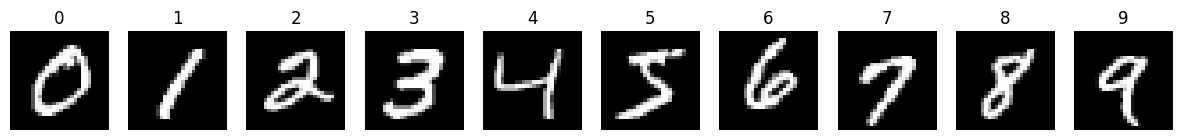

In [5]:
import matplotlib.pyplot as plt

# Obtener un batch
images, labels = next(iter(train_mnist))
print("Batch shape:", images.shape)
print("Etiquetas en este batch:", labels[:10].tolist())

# Clases presentes en el dataset
all_classes = set(train_mnist.dataset.targets.numpy())
print("Clases únicas en MNIST:", all_classes)

# Mostrar un ejemplo de cada clase
fig, axes = plt.subplots(1, 10, figsize=(15,2))
for digit in range(10):
    idx = (train_mnist.dataset.targets == digit).nonzero()[0][0]
    img, lab = train_mnist.dataset[idx]
    axes[digit].imshow(img.squeeze(), cmap="gray")
    axes[digit].set_title(str(lab))
    axes[digit].axis("off")
plt.show()

<a id="centralizado"></a>
## 4. Entrenamiento centralizado (baselines)

Antes de federar, obtendremos referencias centralizadas:

- **KDDCup99**: *Logistic Regression* y *Random Forest* (scikit-learn).
- **MNIST**: MLP/CNN simple (PyTorch).

Guardaremos métricas (accuracy, macro-F1, ROC-AUC, matriz de confusión) y tiempos aproximados.


### 📎 Nota interpretativa de métricas
**Qué medimos y por qué:**
- **Accuracy**: proporción de aciertos totales. Útil, pero puede ser optimista si hay desbalance.
- **Precision**: de las predicciones positivas, ¿cuántas son correctas?  
- **Recall**: de los positivos reales, ¿cuántos detectamos?
- **F1**: media armónica de precision y recall (equilibra ambos).
- **Averaging**:
  - **macro**: media simple por clase (todas las clases pesan igual) ⇒ sensible a minoritarias.
  - **weighted**: media ponderada por *support* ⇒ “favorece” mayoritarias.
- **Support**: nº de ejemplos reales de cada clase en el conjunto evaluado (tamaño de la fila en la matriz de confusión).



### 4.1 KDD — Preparación del baseline
Construimos el **pipeline de preprocesado** (one-hot a categóricas + escalado a numéricas), definimos el **split** y dejamos listas las variables.


In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Selección de columnas
cat_cols = [c for c in ['protocol_type','service','flag'] if c in df_kdd.columns]
num_cols = [c for c in df_kdd.columns if c not in cat_cols + ['class']]

# OneHotEncoder: compatibilidad con versiones de sklearn
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

pre = ColumnTransformer([
    ('onehot', ohe, cat_cols),
    ('scale',  StandardScaler(with_mean=False), num_cols),
])

X = df_kdd[cat_cols + num_cols]
y = df_kdd['class'].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape, "N clases:", y.nunique())


Train: (395216, 41) Test: (98804, 41) N clases: 23


#### 4.1.1 KDD — Modelos y funciones
Definimos una **función genérica** para entrenar y evaluar clasificadores de scikit-learn:
- **Entrenamiento**: `Pipeline(pre + clf).fit(...)`
- **Evaluación**: *accuracy* y *macro-F1* (importante en datasets desbalanceados).


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from time import time
import pandas as pd

def train_eval_clf(clf, name):
    pipe = Pipeline([('pre', pre), ('clf', clf)])
    t0 = time()
    pipe.fit(X_train, y_train)
    dt = time() - t0

    y_pred = pipe.predict(X_test)
    acc  = accuracy_score(y_test, y_pred)
    f1m  = f1_score(y_test, y_pred, average='macro')
    rep  = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    print(f"[{name}] tiempo={dt:.2f}s  acc={acc:.4f}  macro-F1={f1m:.4f}")
    print("macro avg:", {k: round(rep['macro avg'][k],4) for k in ['precision','recall','f1-score']})
    return pipe, {'time': dt, 'acc': acc, 'macro_f1': f1m}

# Entrenamos los dos baselines
logreg_model, logreg_metrics = train_eval_clf(LogisticRegression(max_iter=200), "LogReg")
rf_model,     rf_metrics     = train_eval_clf(RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42), "RandomForest")

central_kdd_results = pd.DataFrame([logreg_metrics, rf_metrics], index=["LogReg","RandomForest"])
central_kdd_results


[LogReg] tiempo=38.86s  acc=0.9993  macro-F1=0.7845
macro avg: {'precision': 0.7992, 'recall': 0.787, 'f1-score': 0.7845}
[RandomForest] tiempo=10.84s  acc=0.9998  macro-F1=0.6922
macro avg: {'precision': 0.714, 'recall': 0.6802, 'f1-score': 0.6922}


time       acc  macro_f1
LogReg        38.859913  0.999261  0.784510
RandomForest  10.839223  0.999787  0.692196

#### 4.1.2 KDD — Comparación rápida de métricas
Comparamos **accuracy** y **macro-F1** de ambos modelos centralizados.


In [8]:
ax = central_kdd_results[['acc','macro_f1']].plot(kind='bar', rot=0, title='KDD (centralizado): Acc y Macro-F1')
ax.set_ylabel('Score'); plt.tight_layout(); plt.show()

#### 4.1.3 KDD — Métricas y visualización
Calculamos métricas clásicas de clasificación (**accuracy**, **precision**, **recall**, **macro-F1**, **weighted-F1**), mostramos el **classification report**, y dibujamos la **matriz de confusión** (top-10 clases por frecuencia para una lectura clara).  
También comparamos visualmente **LogReg** y **RandomForest**.


In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

# y_true y X_test/y_test provienen de 4.1
y_true = y_test.values

# --- Predicciones de ambos modelos centralizados (ya entrenados arriba) ---
y_pred_lr  = logreg_model.predict(X_test)
y_pred_rf  = rf_model.predict(X_test)

# Probabilidades (si el modelo las expone) para ROC-AUC macro OVR
y_proba_lr = logreg_model.predict_proba(X_test) if hasattr(logreg_model, "predict_proba") else None
y_proba_rf = rf_model.predict_proba(X_test) if hasattr(rf_model, "predict_proba") else None

def agg_metrics(y_true, y_pred, y_proba=None):
    """Devuelve todas las métricas agregadas: accuracy, precision/recall/F1 (macro y weighted) + ROC-AUC macro OVR si aplica."""
    acc   = accuracy_score(y_true, y_pred)
    precM = precision_score(y_true, y_pred, average='macro',   zero_division=0)
    precW = precision_score(y_true, y_pred, average='weighted',zero_division=0)
    recM  = recall_score( y_true, y_pred, average='macro',     zero_division=0)
    recW  = recall_score( y_true, y_pred, average='weighted',  zero_division=0)
    f1M   = f1_score(     y_true, y_pred, average='macro',     zero_division=0)
    f1W   = f1_score(     y_true, y_pred, average='weighted',  zero_division=0)
    rocM  = None
    if y_proba is not None and len(np.unique(y_true)) > 2:
        try:
            rocM = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
        except Exception:
            rocM = None
    return dict(
        accuracy=acc,
        precision_macro=precM,  precision_weighted=precW,
        recall_macro=recM,      recall_weighted=recW,
        f1_macro=f1M,           f1_weighted=f1W,
        roc_auc_macro_ovr=rocM
    )

scores_kdd = pd.DataFrame([
    {'model':'LogReg',      **agg_metrics(y_true, y_pred_lr, y_proba_lr)},
    {'model':'RandomForest',**agg_metrics(y_true, y_pred_rf, y_proba_rf)},
]).set_index('model').round(4)

display(scores_kdd)


accuracy  precision_macro  precision_weighted  recall_macro  \
model                                                                       
LogReg          0.9993           0.7992              0.9992        0.7870   
RandomForest    0.9998           0.7140              0.9997        0.6802   

              recall_weighted  f1_macro  f1_weighted roc_auc_macro_ovr  
model                                                                   
LogReg                 0.9993    0.7845       0.9992              None  
RandomForest           0.9998    0.6922       0.9997              None

#### KDD — Matriz de confusión (Top-10 por soporte)

**Idea**: la matriz de confusión muestra **dónde** se cometen los errores (filas = reales, columnas = predichas).  
Para KDD hay muchas clases; mostramos las **10 con más *support*** (más frecuentes) y versión **normalizada** por fila.


== LogReg: Confusión Top-10 ==


== LogReg: Confusión Top-10 (normalizada) ==


== RandomForest: Confusión Top-10 ==


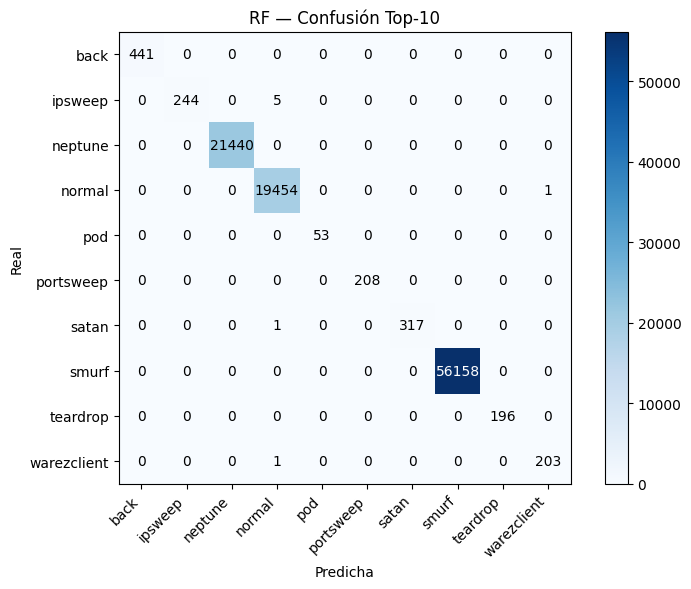

== RandomForest: Confusión Top-10 (normalizada) ==


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix_topk(y_true, y_pred, k=10, normalize=False, title="Confusión Top-10"):
    # Selección Top-k por soporte (clases más frecuentes en y_true)
    vc = pd.Series(y_true).value_counts()
    topk = vc.head(k).index.tolist()

    mask = pd.Series(y_true).isin(topk)
    yt, yp = pd.Series(y_true)[mask], pd.Series(y_pred)[mask]
    labels = sorted(topk)

    cm = confusion_matrix(yt, yp, labels=labels)
    if normalize:
        with np.errstate(all='ignore'):
            cm = cm / cm.sum(axis=1, keepdims=True)
            cm = np.nan_to_num(cm)

    fig, ax = plt.subplots(figsize=(8,6))
    im = ax.imshow(cm, cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(labels)), yticks=np.arange(len(labels)),
        xticklabels=labels, yticklabels=labels,
        xlabel='Predicha', ylabel='Real',
        title=title + (' (normalizada)' if normalize else '')
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout(); plt.show()

print("== LogReg: Confusión Top-10 ==")
plot_confusion_matrix_topk(y_true, y_pred_lr, k=10, normalize=False, title="LogReg — Confusión Top-10")
print("== LogReg: Confusión Top-10 (normalizada) ==")
plot_confusion_matrix_topk(y_true, y_pred_lr, k=10, normalize=True,  title="LogReg — Confusión Top-10")

print("== RandomForest: Confusión Top-10 ==")
plot_confusion_matrix_topk(y_true, y_pred_rf, k=10, normalize=False, title="RF — Confusión Top-10")
print("== RandomForest: Confusión Top-10 (normalizada) ==")
plot_confusion_matrix_topk(y_true, y_pred_rf, k=10, normalize=True,  title="RF — Confusión Top-10")


#### KDD — Informe por clase y “support”

Mostramos el **informe por clase** de scikit-learn.  
**“support” = nº de ejemplos reales de esa clase en test** (sirve para interpretar la fiabilidad del *score* por clase).


In [11]:
from sklearn.metrics import classification_report

# Informe detallado (incluye filas 'macro avg' y 'weighted avg')
rep_lr = classification_report(y_true, y_pred_lr, output_dict=True, zero_division=0)
rep_rf = classification_report(y_true, y_pred_rf, output_dict=True, zero_division=0)

print("== LogReg — classification_report ==")
display(pd.DataFrame(rep_lr).T.round(3))
print("== RandomForest — classification_report ==")
display(pd.DataFrame(rep_rf).T.round(3))


== LogReg — classification_report ==


precision  recall  f1-score    support
back                 0.993   0.995     0.994    441.000
buffer_overflow      0.833   0.833     0.833      6.000
ftp_write            1.000   0.500     0.667      2.000
guess_passwd         1.000   0.909     0.952     11.000
imap                 0.500   0.500     0.500      2.000
ipsweep              0.984   0.964     0.974    249.000
land                 1.000   1.000     1.000      4.000
loadmodule           0.000   0.000     0.000      2.000
multihop             0.000   0.000     0.000      1.000
neptune              1.000   1.000     1.000  21440.000
nmap                 0.880   0.957     0.917     46.000
normal               0.999   0.998     0.998  19455.000
perl                 1.000   1.000     1.000      1.000
phf                  0.500   1.000     0.667      1.000
pod                  1.000   0.981     0.990     53.000
portsweep            0.986   0.990     0.988    208.000
rootkit              0.000   0.000     0.000      2.000
satan                0.997   0.991     0.994    318.000
smurf                1.000   1.000     1.000  56158.000
teardrop             1.000   1.000     1.000    196.000
warezclient          0.910   0.946     0.928    204.000
warezmaster          1.000   0.750     0.857      4.000
accuracy             0.999   0.999     0.999      0.999
macro avg            0.799   0.787     0.785  98804.000
weighted avg         0.999   0.999     0.999  98804.000

== RandomForest — classification_report ==


precision  recall  f1-score  support
back                 1.000   1.000     1.000    441.0
buffer_overflow      0.714   0.833     0.769      6.0
ftp_write            0.000   0.000     0.000      2.0
guess_passwd         1.000   0.909     0.952     11.0
imap                 1.000   0.500     0.667      2.0
ipsweep              1.000   0.980     0.990    249.0
land                 1.000   1.000     1.000      4.0
loadmodule           0.000   0.000     0.000      2.0
multihop             0.000   0.000     0.000      1.0
neptune              1.000   1.000     1.000  21440.0
nmap                 1.000   1.000     1.000     46.0
normal               0.999   1.000     1.000  19455.0
perl                 0.000   0.000     0.000      1.0
phf                  0.000   0.000     0.000      1.0
pod                  1.000   1.000     1.000     53.0
portsweep            1.000   1.000     1.000    208.0
rootkit              0.000   0.000     0.000      2.0
satan                1.000   0.997     0.998    318.0
smurf                1.000   1.000     1.000  56158.0
teardrop             1.000   1.000     1.000    196.0
warezclient          0.995   0.995     0.995    204.0
warezmaster          1.000   0.750     0.857      4.0
accuracy             1.000   1.000     1.000      1.0
macro avg            0.714   0.680     0.692  98804.0
weighted avg         1.000   1.000     1.000  98804.0

### 4.2 MNIST — Preparación del baseline
Definimos el **dispositivo** (CPU/GPU) y la **CNN**. La CNN tiene:
- Bloques **Conv2d + ReLU + MaxPool** (extracción de características).
- Capas **Lineales** finales para la clasificación (10 dígitos).

### · CNN de referencia (explicación breve)

Una **red neuronal convolucional (CNN)** compone **operadores lineales** (p. ej., convoluciones, capas densas) con **no linealidades** (p. ej., ReLU) y operaciones de **submuestreo** (p. ej., *max pooling*). La idea es extraer **características jerárquicas**: de bordes y trazos a patrones más abstractos.

Vamos a usar una red muy sencilla para reconocer dígitos escritos a mano (MNIST).  
La idea es que la red **reciba una imagen (28x28 píxeles)** y produzca como salida un número del 0 al 9.

🔹 **Capas principales y su función:**
- **Convolución (Conv2d):** mira la imagen con “ventanas” pequeñas (filtros) para encontrar patrones simples, como líneas o esquinas.
- **ReLU:** deja pasar solo valores positivos (introduce no linealidad).  
- **MaxPooling:** reduce el tamaño de la imagen quedándose con el valor más fuerte en cada zona (resumen de información).  
- **Flatten:** estira los mapas de características en un vector 1D.  
- **Linear (capa densa):** combina toda la información y da como resultado 10 valores (uno por cada dígito posible).

👉 El flujo es: **imagen 28x28 → filtros que detectan rasgos → resumen con pooling → más filtros → vector → capas densas → predicción (0–9)**.


#### 📌 Detalle de la arquitectura CNN

Nuestra red está compuesta por capas con parámetros numéricos que indican cuántas **entradas → salidas** tiene cada bloque:

- **`nn.Conv2d(1, 16, 3, padding=1)`**  
  - `1` → número de canales de entrada (imagen en escala de grises).  
  - `16` → filtros que aprende la red (16 mapas de salida).  
  - `3` → tamaño del filtro (3×3 píxeles).  
  - `padding=1` → se añade un borde de 1 píxel para mantener tamaño (28×28).  

- **`nn.ReLU()`**  
  - Activa solo valores positivos, introduciendo no linealidad.  

- **`nn.MaxPool2d(2)`**  
  - Reduce a la mitad el tamaño espacial (28×28 → 14×14).  

- **`nn.Conv2d(16, 32, 3, padding=1)`**  
  - `16` canales de entrada (de la capa anterior).  
  - `32` filtros aprendidos (32 mapas de salida).  
  - `3` tamaño de filtro, `padding=1` mantiene dimensiones.  

- **`nn.MaxPool2d(2)`**  
  - Segunda reducción: 14×14 → 7×7.  

- **`nn.Flatten()`**  
  - Convierte la salida en un vector: 32 mapas × 7×7 = **1568 valores**.  

- **`nn.Linear(32*7*7, 128)`**  
  - `1568` entradas → `128` neuronas ocultas.  

- **`nn.Linear(128, 10)`**  
  - `128` entradas → `10` salidas (una por cada dígito 0–9).  

👉 En resumen: la red transforma **imágenes 28×28** en **10 valores de salida**, cada uno indicando la probabilidad de que la imagen sea un dígito del 0 al 9.


In [12]:
import torch, torch.nn as nn, torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleCNN(nn.Module):
    """Conv(1→16)→ReLU→Pool → Conv(16→32)→ReLU→Pool → Flatten → FC(128)→ReLU→FC(10)"""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),   # 28→14
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 14→7
            nn.Flatten(),
            nn.Linear(32*7*7, 128), nn.ReLU(),
            nn.Linear(128, 10),
        )
    def forward(self, x): 
        return self.net(x)


#### 4.2.1 MNIST — Funciones de entrenamiento y evaluación
- **`train_epoch`**: una pasada por `train_mnist` (forward → loss → backward → step).
- **`eval_acc`**: *accuracy* en `test_mnist` (modo evaluación, sin gradientes).


In [13]:
def train_epoch(model, loader, criterion, opt):
    model.train(); loss_sum=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        opt.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        opt.step()
        loss_sum += loss.item()*x.size(0)
    return loss_sum/len(loader.dataset)

@torch.no_grad()
def eval_acc(model, loader):
    model.eval(); correct=0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        pred = model(x).argmax(1)
        correct += (pred==y).sum().item()
    return correct/len(loader.dataset)


#### 4.2.2 MNIST — Entrenamiento centralizado
Entrenamos **3 épocas** y reportamos *loss* de entrenamiento y *accuracy* en test por época.


In [14]:
cnn = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(cnn.parameters(), lr=1e-3)

from time import time
t0 = time()
for epoch in range(3):
    tr_loss = train_epoch(cnn, train_mnist, criterion, opt)
    acc = eval_acc(cnn, test_mnist)
    print(f"Epoch {epoch+1}: loss={tr_loss:.4f}  acc={acc:.4f}")
print("Tiempo total (MNIST centralizado):", f"{time()-t0:.1f}s")


Epoch 1: loss=0.2987  acc=0.9681
Epoch 2: loss=0.0752  acc=0.9831
Epoch 3: loss=0.0531  acc=0.9833
Tiempo total (MNIST centralizado): 21.7s


#### 4.2.3 MNIST — Métricas y visualización
Calculamos **accuracy**, **precision**, **recall**, **macro-F1**, **weighted-F1**, mostramos el **classification report** y la **matriz de confusión** (10×10).


In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Recolectar predicciones completas en test
y_true_m, y_pred_m = [], []
cnn.eval()
with torch.no_grad():
    for xb, yb in test_mnist:
        xb = xb.to(device)
        preds = cnn(xb).argmax(1).cpu().numpy()
        y_true_m.extend(yb.numpy())
        y_pred_m.extend(preds)

y_true_m = np.array(y_true_m); y_pred_m = np.array(y_pred_m)

scores_mnist = pd.DataFrame([{
    'accuracy':           accuracy_score(y_true_m, y_pred_m),
    'precision_macro':    precision_score(y_true_m, y_pred_m, average='macro',    zero_division=0),
    'precision_weighted': precision_score(y_true_m, y_pred_m, average='weighted', zero_division=0),
    'recall_macro':       recall_score(  y_true_m, y_pred_m, average='macro',     zero_division=0),
    'recall_weighted':    recall_score(  y_true_m, y_pred_m, average='weighted',  zero_division=0),
    'f1_macro':           f1_score(      y_true_m, y_pred_m, average='macro',     zero_division=0),
    'f1_weighted':        f1_score(      y_true_m, y_pred_m, average='weighted',  zero_division=0),
}]).round(4)

display(scores_mnist)


accuracy  precision_macro  precision_weighted  recall_macro  \
0    0.9833           0.9834              0.9835        0.9832   

   recall_weighted  f1_macro  f1_weighted  
0           0.9833    0.9832       0.9833

#### Matriz de confusión

La matriz 10×10 (clases 0–9) permite identificar **dígitos que se confunden** con más frecuencia.  
Mostramos versión **absoluta** y **normalizada** por fila.

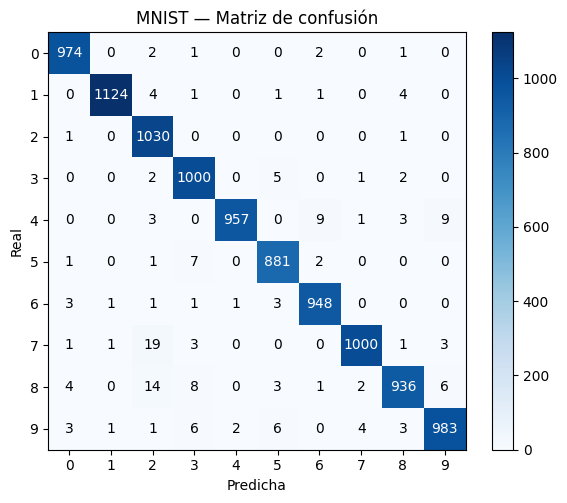

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels_10 = list(range(10))
cm_abs = confusion_matrix(y_true_m, y_pred_m, labels=labels_10)
cm_norm = cm_abs / cm_abs.sum(axis=1, keepdims=True)

def plot_cm(cm, labels, title, normalize=False):
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cm, cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(labels)), yticks=np.arange(len(labels)),
        xticklabels=labels, yticklabels=labels,
        xlabel='Predicha', ylabel='Real',
        title=title + (' (normalizada)' if normalize else '')
    )
    th = np.nanmax(cm)/2
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            if np.isnan(val): val = 0.0
            ax.text(j, i, format(val, fmt), ha='center', va='center',
                    color='white' if val > th else 'black')
    plt.tight_layout(); plt.show()

plot_cm(cm_abs,  labels_10, "MNIST — Matriz de confusión", normalize=False)
plot_cm(cm_norm, labels_10, "MNIST — Matriz de confusión", normalize=True)


#### Informe por clase y “support”

El **classification_report** muestra métricas **por clase** y agrega las filas **macro avg** y **weighted avg**.  
**“support”** indica cuántas imágenes reales de cada dígito hay en test.  
En MNIST, el soporte por clase es similar; por eso **macro** y **weighted** suelen ser parecidas.

In [17]:
from sklearn.metrics import classification_report
rep_m = classification_report(y_true_m, y_pred_m, output_dict=True, zero_division=0)
display(pd.DataFrame(rep_m).T.round(3))


precision  recall  f1-score    support
0                 0.987   0.994     0.990    980.000
1                 0.997   0.990     0.994   1135.000
2                 0.956   0.998     0.977   1032.000
3                 0.974   0.990     0.982   1010.000
4                 0.997   0.975     0.986    982.000
5                 0.980   0.988     0.984    892.000
6                 0.984   0.990     0.987    958.000
7                 0.992   0.973     0.982   1028.000
8                 0.984   0.961     0.972    974.000
9                 0.982   0.974     0.978   1009.000
accuracy          0.983   0.983     0.983      0.983
macro avg         0.983   0.983     0.983  10000.000
weighted avg      0.983   0.983     0.983  10000.000

### 4.3 Qué retenemos de esta sección
- **Baselines centralizados** listos para comparar con FL:  
  - KDD: *LogReg* vs *RandomForest* → observar **macro-F1** además de **accuracy**.  
  - MNIST: **CNN** con *accuracy* por época.
- Estos resultados serán la **línea base** para evaluar estrategias federadas (FedAvg/FedAdam/FedProx) y particiones (IID/no-IID).


<a id="fl_tabular"></a>
## 5. Introducción a Federated Learning con Flower (tabular: KDD)

A continuación, crearemos una simulación federada con **N** clientes virtuales. Cada cliente mantendrá un subconjunto de KDD y entrenará un **modelo lineal (PyTorch)** compatible con agregación de parámetros (FedAvg, etc.).

Incluimos dos mecanismos de particionado:
- **IID**: partición aleatoria estratificada.
- **No-IID Dirichlet**: mezclas desbalanceadas con parámetro \(\alpha\) (cuanto menor \(\alpha\), mayor heterogeneidad).

Hasta ahora entrenamos modelos centralizados.  
En **Federated Learning (FL)**, en lugar de reunir todos los datos en un servidor,  
se entrena el modelo **directamente en los clientes** y luego se **agregan sus parámetros**.

Arquitectura típica:
- **Servidor**: mantiene el modelo global, coordina rondas y agrega parámetros.
- **Clientes**: entrenan con sus datos locales y devuelven actualizaciones.
- **Estrategia**: define cómo se combinan las actualizaciones (FedAvg, FedAdam, FedProx, etc.).



#### Preparación de datos y modelo local

Primero, necesitamos transformar el dataset tabular (KDD) en tensores de PyTorch y definir un modelo base sencillo (regresión logística).


In [18]:
import torch, torch.nn as nn, torch.optim as optim
from sklearn.pipeline import Pipeline

# Reutilizar el preprocesador ya entrenado (OneHot + escala numérica)
pipe = Pipeline([('pre', pre), ('id', 'passthrough')])
pipe.fit(X_train, y_train)

# Transformar en arrays
X_train_t = torch.tensor(pipe.transform(X_train), dtype=torch.float32)
X_test_t  = torch.tensor(pipe.transform(X_test),  dtype=torch.float32)

# Mapear etiquetas a enteros
classes = sorted(y.unique().tolist())
class_to_idx = {c:i for i,c in enumerate(classes)}
y_train_t = torch.tensor(y_train.map(class_to_idx).values, dtype=torch.long)
y_test_t  = torch.tensor(y_test.map(class_to_idx).values, dtype=torch.long)

input_dim, num_classes = X_train_t.shape[1], len(classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo base: regresión logística en PyTorch
class LogisticTorch(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)
    def forward(self, x): 
        return self.fc(x)


#### Particionado de datos (IID y no-IID)

En FL, los clientes no siempre tienen datos “idénticos”:
- **IID (independiente e idénticamente distribuido):** todos los clientes tienen datos variados y balanceados.
- **no-IID:** cada cliente recibe más datos de unas clases que de otras (más realista).

Usamos dos funciones de particionado:
- `split_iid`: reparte datos de forma uniforme y aleatoria.  
- `split_dirichlet`: reparte siguiendo una distribución de Dirichlet, controlando el grado de heterogeneidad con el parámetro α.


In [19]:
import numpy as np

def split_iid(X, y, num_clients=10, seed=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y)); rng.shuffle(idx)
    return np.array_split(idx, num_clients)

def split_dirichlet(X, y, num_clients=10, alpha=0.5, seed=42):
    rng = np.random.default_rng(seed)
    y_np = y.numpy()
    idx_by_class = {c: np.where(y_np==c)[0] for c in np.unique(y_np)}
    for c in idx_by_class: rng.shuffle(idx_by_class[c])
    client_indices = [[] for _ in range(num_clients)]
    for c, idxs in idx_by_class.items():
        proportions = rng.dirichlet([alpha]*num_clients)
        counts = (proportions * len(idxs)).astype(int)
        while counts.sum() < len(idxs): counts[rng.integers(0,num_clients)] += 1
        start=0
        for cid, cnt in enumerate(counts):
            client_indices[cid].extend(idxs[start:start+cnt])
            start += cnt
    return [np.array(sorted(ci)) for ci in client_indices]


#### Entrenamiento local y evaluación

Cada cliente necesita:
- Una **función de entrenamiento local** (SGD + CrossEntropy).  
- Una **posible extensión FedProx**, que añade un término de regularización respecto a los parámetros globales.  
- Una **función de evaluación** para medir accuracy local/global.


In [20]:
from copy import deepcopy

def make_client_data(indices):
    return X_train_t[indices], y_train_t[indices]

def train_local(model, data, epochs=1, lr=0.1, prox_mu=0.0, global_params=None):
    model = model.to(device)
    Xc, yc = data[0].to(device), data[1].to(device)
    opt = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for _ in range(epochs):
        opt.zero_grad()
        out = model(Xc)
        loss = criterion(out, yc)
        # FedProx: penaliza desviarse de los pesos globales
        if prox_mu>0 and global_params is not None:
            prox_term = sum(((p - w0.to(device))**2).sum() for p,w0 in zip(model.parameters(), global_params))
            loss = loss + (prox_mu/2.0)*prox_term
        loss.backward(); opt.step()
    # Evaluación local (accuracy)
    with torch.no_grad():
        acc = (model(Xc).argmax(1)==yc).float().mean().item()
    return deepcopy(model.state_dict()), len(Xc), {'acc': acc}

def evaluate_model(model, X, y):
    model = model.to(device).eval()
    with torch.no_grad():
        acc = (model(X.to(device)).argmax(1)==y.to(device)).float().mean().item()
    return acc


#### Estrategia y bucle federado

En **Federated Learning**, el servidor necesita una **estrategia de agregación** para combinar las actualizaciones de los clientes y actualizar el modelo global.  
Las más comunes son:

- **FedAvg (Federated Averaging):**  
  Promedia los parámetros de los modelos locales, ponderando por el número de ejemplos de cada cliente.  
  ➝ Simple y eficaz, es la base de la mayoría de experimentos.

- **FedAdam:**  
  Aplica el optimizador **Adam** en el servidor en lugar de un simple promedio.  
  ➝ Puede acelerar la convergencia y manejar mejor escenarios heterogéneos.

- **FedProx:**  
  Modifica la **función de pérdida local** añadiendo un término de regularización respecto al modelo global.  
  ➝ Evita que los clientes se desvíen demasiado cuando sus datos son muy distintos (escenarios no-IID).  
  ➝ En la práctica, usamos la misma agregación que FedAvg, pero el entrenamiento local incluye el término “proximal”.

---

##### 🔄 Bucle federado simplificado
1. **Selección de clientes:** el servidor escoge un subconjunto aleatorio en cada ronda.  
2. **Entrenamiento local:** cada cliente entrena con sus datos durante unas pocas épocas.  
3. **Agregación en el servidor:** se combinan las actualizaciones siguiendo la estrategia elegida (p. ej., FedAvg).  
4. **Evaluación global:** el modelo agregado se prueba en un conjunto de test común o en validaciones locales.  

Este ciclo se repite durante varias rondas hasta estabilizar el rendimiento.



In [21]:
from flwr.server.strategy import FedAvg, FedAdam  # se mantiene el import por compatibilidad (no se usan)

def run_federated(num_rounds=5, num_clients=10, frac_fit=0.5, iid=True, dir_alpha=0.5,
                  local_epochs=1, lr=0.1, strategy_name="FedAvg", prox_mu=0.0):
    # 1. Particionado de datos
    splits = split_iid(X_train_t, y_train_t, num_clients) if iid else \
             split_dirichlet(X_train_t, y_train_t, num_clients, dir_alpha)
    client_data = [make_client_data(idx) for idx in splits]

    # 2. Modelo global inicial
    global_model = LogisticTorch(input_dim, num_classes).to(device)
    params = [p.detach().cpu().clone() for p in global_model.parameters()]  # para FedProx

    # 3. Selector de estrategia (mínimo cambio):
    #    - FedAvg: promedio ponderado (por defecto)
    #    - FedAdam: Adam en servidor sobre Δ = w_agg - w_global
    use_fedadam = (strategy_name == "FedAdam")
    if use_fedadam:
        beta1, beta2, eps, lr_server = 0.9, 0.999, 1e-8, 1.0
        m = {k: torch.zeros_like(v) for k, v in global_model.state_dict().items()}
        v = {k: torch.zeros_like(v) for k, v in global_model.state_dict().items()}
        t = 0  # contador de pasos Adam en servidor

    # 4. Rondas
    hist = {'round':[], 'acc_global':[], 'acc_clients':[]}
    for rnd in range(1, num_rounds+1):
        selected = np.random.default_rng(rnd).choice(
            np.arange(num_clients),
            size=max(1,int(frac_fit*num_clients)),
            replace=False
        )
        updates, client_accs = [], []
        for cid in selected:
            local_model = LogisticTorch(input_dim, num_classes).to(device)
            local_model.load_state_dict(global_model.state_dict())
            sd, n, metrics = train_local(
                local_model, client_data[cid],
                epochs=local_epochs, lr=lr,
                prox_mu=prox_mu,                        # FedProx si >0
                global_params=params if prox_mu>0 else None
            )
            updates.append((sd, n)); client_accs.append(metrics['acc'])

        # Agregación ponderada (promedio de pesos locales)
        total = sum(n for _,n in updates)
        avg_state = {k: torch.zeros_like(v) for k,v in global_model.state_dict().items()}
        for sd, n in updates:
            w = n/total
            for k in avg_state:
                avg_state[k] += sd[k]*w

        if use_fedadam:
            # FedAdam en servidor: Adam sobre Δ = w_agg - w_global (mínimo código nuevo)
            t += 1
            new_state = {}
            curr_state = global_model.state_dict()
            for k in avg_state:
                delta = avg_state[k] - curr_state[k]
                m[k] = beta1*m[k] + (1-beta1)*delta
                v[k] = beta2*v[k] + (1-beta2)*(delta*delta)
                m_hat = m[k] / (1 - beta1**t)
                v_hat = v[k] / (1 - beta2**t)
                new_state[k] = curr_state[k] + lr_server * (m_hat / (torch.sqrt(v_hat) + eps))
        else:
            # FedAvg: sustituir por el promedio ponderado
            new_state = avg_state

        global_model.load_state_dict(new_state)
        params = [p.detach().cpu().clone() for p in global_model.parameters()]  # refresco para FedProx

        acc_g = evaluate_model(global_model, X_test_t, y_test_t)
        hist['round'].append(rnd); hist['acc_global'].append(acc_g); hist['acc_clients'].append(float(np.mean(client_accs)))
        print(f"Ronda {rnd:02d} | acc_test={acc_g:.4f} | acc_client_mean={np.mean(client_accs):.4f}")

    return global_model, hist


##### 5.4.1 · Ejecución base con FedAvg (IID)

Primero corremos un experimento **IID** con **FedAvg** para tener una referencia federada.


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Diccionario para guardar historiales de runs
histories = {}

print("\n== FedAvg (IID) ==")
global_model_fedavg_iid, h_fedavg_iid = run_federated(
    num_rounds=10,         # rondas federadas
    num_clients=10,        # nº de clientes virtuales
    frac_fit=0.5,          # fracción de clientes por ronda
    iid=True,              # particionado IID
    dir_alpha=0.5,         # irrelevante en IID (se ignora)
    local_epochs=1,        # épocas locales por cliente
    lr=0.1,                # tasa de aprendizaje local
    strategy_name="FedAvg",
    prox_mu=0.0            # sin término proximal
)
histories['FedAvg_IID'] = h_fedavg_iid
print("Historial guardado:", list(histories.keys()))



== FedAvg (IID) ==
Ronda 01 | acc_test=0.7474 | acc_client_mean=0.7486
Ronda 02 | acc_test=0.7912 | acc_client_mean=0.7915
Ronda 03 | acc_test=0.8037 | acc_client_mean=0.8035
Ronda 04 | acc_test=0.8262 | acc_client_mean=0.8255
Ronda 05 | acc_test=0.8836 | acc_client_mean=0.8841
Ronda 06 | acc_test=0.9350 | acc_client_mean=0.9340
Ronda 07 | acc_test=0.9477 | acc_client_mean=0.9477
Ronda 08 | acc_test=0.9500 | acc_client_mean=0.9493
Ronda 09 | acc_test=0.9517 | acc_client_mean=0.9510
Ronda 10 | acc_test=0.9535 | acc_client_mean=0.9530
Historial guardado: ['FedAvg_IID']


In [23]:
# === Métricas agregadas en test con el modelo global final ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
global_model_fedavg_iid = global_model_fedavg_iid.to(device).eval()
with torch.no_grad():
    logits = global_model_fedavg_iid(X_test_t.to(device))
    y_pred_idx = logits.argmax(1).cpu().numpy()
y_true_idx = y_test_t.numpy()

# (Opcional) mapeo a etiquetas originales por si quieres usarlas después (matriz de confusión)
idx_to_class = {i: c for c, i in class_to_idx.items()}
y_true_lab = np.array([idx_to_class[i] for i in y_true_idx])
y_pred_lab = np.array([idx_to_class[i] for i in y_pred_idx])

# Cálculo de métricas (macro y weighted)
metrics = pd.DataFrame([{
    "accuracy":            accuracy_score(y_true_idx, y_pred_idx),
    "precision_macro":     precision_score(y_true_idx, y_pred_idx, average="macro",    zero_division=0),
    "precision_weighted":  precision_score(y_true_idx, y_pred_idx, average="weighted", zero_division=0),
    "recall_macro":        recall_score(y_true_idx, y_pred_idx,    average="macro",    zero_division=0),
    "recall_weighted":     recall_score(y_true_idx, y_pred_idx,    average="weighted", zero_division=0),
    "f1_macro":            f1_score(y_true_idx, y_pred_idx,        average="macro",    zero_division=0),
    "f1_weighted":         f1_score(y_true_idx, y_pred_idx,        average="weighted", zero_division=0),
}]).round(4)

print("== Métricas agregadas (FedAvg, IID) ==")
display(metrics)


== Métricas agregadas (FedAvg, IID) ==


accuracy  precision_macro  precision_weighted  recall_macro  \
0    0.9535           0.1303              0.9368        0.1297   

   recall_weighted  f1_macro  f1_weighted  
0           0.9535    0.1299       0.9442

Mostramos la **matriz de confusión** (absoluta y normalizada por filas) sobre las **Top-10 clases por *support*** para que sea legible en KDD.  
> *support* = nº de ejemplos reales de cada clase en test.

== Matriz de confusión (Top-10) — ABSOLUTA ==


== Matriz de confusión (Top-10) — NORMALIZADA ==


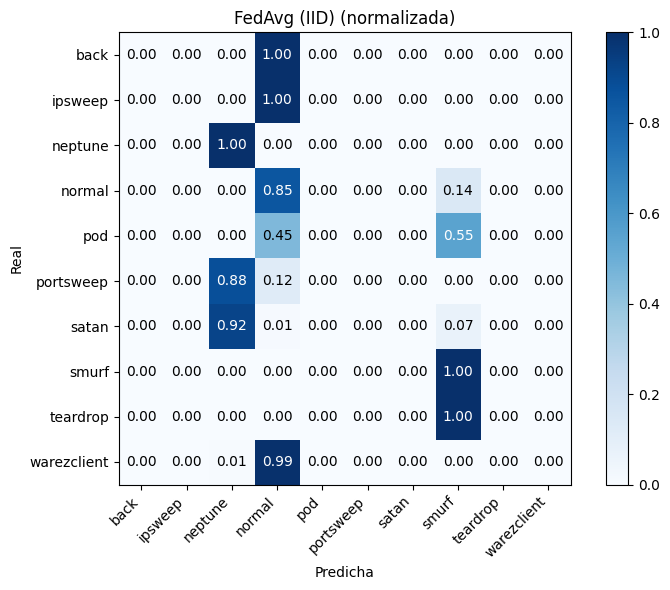

In [24]:
# === Solo visualización de matriz de confusión (usa y_true_lab / y_pred_lab de la celda anterior) ===
def plot_confusion_matrix_topk(y_true, y_pred, k=10, normalize=False, title="Confusión Top-10"):
    # Selección Top-k por soporte (clases más frecuentes en y_true)
    vc = pd.Series(y_true).value_counts()
    topk = vc.head(k).index.tolist()

    mask = pd.Series(y_true).isin(topk)
    yt, yp = pd.Series(y_true)[mask], pd.Series(y_pred)[mask]
    labels = sorted(topk)  # orden estable para ejes

    cm = confusion_matrix(yt, yp, labels=labels)
    if normalize:
        with np.errstate(all='ignore'):
            cm = cm / cm.sum(axis=1, keepdims=True)
            cm = np.nan_to_num(cm)

    fig, ax = plt.subplots(figsize=(8,6))
    im = ax.imshow(cm, cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(labels)), yticks=np.arange(len(labels)),
        xticklabels=labels, yticklabels=labels,
        xlabel='Predicha', ylabel='Real',
        title=title + (' (normalizada)' if normalize else '')
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout(); plt.show()

print("== Matriz de confusión (Top-10) — ABSOLUTA ==")
plot_confusion_matrix_topk(y_true_lab, y_pred_lab, k=10, normalize=False, title="FedAvg (IID)")
print("== Matriz de confusión (Top-10) — NORMALIZADA ==")
plot_confusion_matrix_topk(y_true_lab, y_pred_lab, k=10, normalize=True,  title="FedAvg (IID)")


##### 5.4.2 · Comparar estrategias (FedAdam y FedProx)

Ejecutamos **FedAdam (IID)** y **FedProx (IID)** para comparar con el **FedAvg (IID)** ya obtenido.

In [25]:
# Asegura diccionario de historiales
if 'histories' not in globals():
    histories = {}

print("\n== FedAdam (IID) ==")
_, h_fedadam_iid = run_federated(
    num_rounds=10, num_clients=10, frac_fit=0.5,
    iid=True, local_epochs=1, lr=0.1,
    strategy_name="FedAdam", prox_mu=0.0
)
histories['FedAdam_IID'] = h_fedadam_iid

print("\n== FedProx (IID, μ=0.1) ==")
_, h_fedprox_iid = run_federated(
    num_rounds=10, num_clients=10, frac_fit=0.5,
    iid=True, local_epochs=1, lr=0.1,
    strategy_name="FedAvg", prox_mu=0.1    # prox_mu>0 activa FedProx (agregación tipo FedAvg)
)
histories['FedProx_IID_mu0.1'] = h_fedprox_iid

print("Historial guardado:", list(histories.keys()))



== FedAdam (IID) ==
Ronda 01 | acc_test=0.9787 | acc_client_mean=0.5704
Ronda 02 | acc_test=0.9802 | acc_client_mean=0.9808
Ronda 03 | acc_test=0.9834 | acc_client_mean=0.9804
Ronda 04 | acc_test=0.9841 | acc_client_mean=0.9838
Ronda 05 | acc_test=0.9839 | acc_client_mean=0.9848
Ronda 06 | acc_test=0.9860 | acc_client_mean=0.9843
Ronda 07 | acc_test=0.9860 | acc_client_mean=0.9862
Ronda 08 | acc_test=0.9856 | acc_client_mean=0.9862
Ronda 09 | acc_test=0.9839 | acc_client_mean=0.9854
Ronda 10 | acc_test=0.9882 | acc_client_mean=0.9838

== FedProx (IID, μ=0.1) ==
Ronda 01 | acc_test=0.5891 | acc_client_mean=0.5890
Ronda 02 | acc_test=0.7090 | acc_client_mean=0.7108
Ronda 03 | acc_test=0.8149 | acc_client_mean=0.8143
Ronda 04 | acc_test=0.8623 | acc_client_mean=0.8622
Ronda 05 | acc_test=0.8977 | acc_client_mean=0.8990
Ronda 06 | acc_test=0.9392 | acc_client_mean=0.9389
Ronda 07 | acc_test=0.9415 | acc_client_mean=0.9413
Ronda 08 | acc_test=0.9428 | acc_client_mean=0.9420
Ronda 09 | acc_

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def metrics_for_model(model):
    model = model.to(device).eval()
    with torch.no_grad():
        y_pred_idx = model(X_test_t.to(device)).argmax(1).cpu().numpy()
    y_true_idx = y_test_t.numpy()
    return dict(
        accuracy           = accuracy_score(y_true_idx, y_pred_idx),
        precision_macro    = precision_score(y_true_idx, y_pred_idx, average="macro",    zero_division=0),
        precision_weighted = precision_score(y_true_idx, y_pred_idx, average="weighted", zero_division=0),
        recall_macro       = recall_score(  y_true_idx, y_pred_idx, average="macro",     zero_division=0),
        recall_weighted    = recall_score(  y_true_idx, y_pred_idx, average="weighted",  zero_division=0),
        f1_macro           = f1_score(      y_true_idx, y_pred_idx, average="macro",     zero_division=0),
        f1_weighted        = f1_score(      y_true_idx, y_pred_idx, average="weighted",  zero_division=0),
    )

rows = []
available = [
    ("FedAvg_IID",  globals().get("global_model_fedavg_iid",  None)),
    ("FedAdam_IID", globals().get("global_model_fedadam_iid", None)),
    ("FedProx_IID", globals().get("global_model_fedprox_iid", None)),
]
for name, model in available:
    if model is not None:
        rows.append({"estrategia": name, **metrics_for_model(model)})

if rows:
    metrics_iid = pd.DataFrame(rows).set_index("estrategia").round(4)
    display(metrics_iid)
else:
    raise RuntimeError(
        "No se encontraron modelos IID en memoria. Asegúrate de haber guardado "
        "global_model_fedavg_iid / global_model_fedadam_iid / global_model_fedprox_iid al entrenar."
    )


accuracy  precision_macro  precision_weighted  recall_macro  \
estrategia                                                                
FedAvg_IID    0.9535           0.1303              0.9368        0.1297   

            recall_weighted  f1_macro  f1_weighted  
estrategia                                          
FedAvg_IID           0.9535    0.1299       0.9442

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
idx_to_class = {i: c for c, i in class_to_idx.items()}  # índice → etiqueta original

def predict_labels(model):
    """Devuelve (y_true_lab, y_pred_lab) para el modelo dado, sin reentrenar."""
    model = model.to(device).eval()
    with torch.no_grad():
        y_pred_idx = model(X_test_t.to(device)).argmax(1).cpu().numpy()
    y_true_idx = y_test_t.numpy()
    y_true_lab = np.array([idx_to_class[i] for i in y_true_idx])
    y_pred_lab = np.array([idx_to_class[i] for i in y_pred_idx])
    return y_true_lab, y_pred_lab

def plot_confusion_matrix_topk(y_true, y_pred, k=10, normalize=False, title="Confusión Top-10"):
    """Matriz de confusión para las k clases con mayor support (sin seaborn)."""
    vc = pd.Series(y_true).value_counts()
    topk = vc.head(k).index.tolist()
    mask = pd.Series(y_true).isin(topk)
    yt, yp = pd.Series(y_true)[mask], pd.Series(y_pred)[mask]
    labels = sorted(topk)
    cm = confusion_matrix(yt, yp, labels=labels)
    if normalize:
        with np.errstate(all='ignore'):
            cm = cm / cm.sum(axis=1, keepdims=True)
            cm = np.nan_to_num(cm)

    fig, ax = plt.subplots(figsize=(8,6))
    im = ax.imshow(cm, cmap='Blues'); ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(labels)), yticks=np.arange(len(labels)),
           xticklabels=labels, yticklabels=labels,
           xlabel='Predicha', ylabel='Real',
           title=title + (' (normalizada)' if normalize else ''))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    fmt = '.2f' if normalize else 'd'; thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout(); plt.show()

# Solo estrategias IID distintas de FedAvg:
models_iid = [
    ("FedAdam (IID)",  globals().get("global_model_fedadam_iid", None)),
    ("FedProx (IID)",  globals().get("global_model_fedprox_iid", None)),
]

for name, mdl in models_iid:
    if mdl is None:
        continue
    y_true_lab, y_pred_lab = predict_labels(mdl)
    print(f"== {name}: Matriz de confusión (Top-10) — ABSOLUTA ==")
    plot_confusion_matrix_topk(y_true_lab, y_pred_lab, k=10, normalize=False, title=name)
    print(f"== {name}: Matriz de confusión (Top-10) — NORMALIZADA ==")
    plot_confusion_matrix_topk(y_true_lab, y_pred_lab, k=10, normalize=True,  title=name)


##### 5.4.3 · Escenario no-IID: visualizar cómo quedan las particiones por cliente

Mostramos la **distribución de clases** por cliente bajo Dirichlet (α=0.5).  
Para no saturar el gráfico (KDD tiene muchas clases), dibujamos las **Top-6** clases globales y agregamos el resto como **“otras”**.


In [28]:
# 1) Generar una partición no-IID que usaremos solo para visualizar
num_clients = 10
alpha = 0.1
splits_noiid = split_dirichlet(X_train_t, y_train_t, num_clients=num_clients, alpha=alpha, seed=123)

# 2) Conteo por cliente y por clase
y_np = y_train_t.numpy()
classes_sorted = sorted(classes)  # nombres de clases (strings) en orden estable
# Mapa entero->nombre
idx_to_class = {i:c for c,i in class_to_idx.items()}

# Conteo global para escoger Top-6
global_counts = pd.Series([idx_to_class[i] for i in y_np]).value_counts()
topk_labels = global_counts.head(6).index.tolist()

# Tabla cliente x clase (%)
dist_rows = []
for cid, idxs in enumerate(splits_noiid):
    labs = [idx_to_class[i] for i in y_np[idxs]]
    vc = pd.Series(labs).value_counts()
    total = vc.sum()
    row = {lab: (vc.get(lab, 0)/total) for lab in topk_labels}
    row['otras'] = 1.0 - sum(row.values())
    dist_rows.append(row)

df_client_dist = pd.DataFrame(dist_rows)
df_client_dist.index = [f"C{cid}" for cid in range(num_clients)]
df_client_dist = df_client_dist[topk_labels + ['otras']].round(3)
display(df_client_dist)

# 3) Gráfico apilado por cliente (Top-6 + otras)
plt.figure(figsize=(10,5))
bottom = np.zeros(len(df_client_dist))
x = np.arange(len(df_client_dist))
for col in df_client_dist.columns:
    plt.bar(x, df_client_dist[col].values, bottom=bottom, label=col)
    bottom += df_client_dist[col].values
plt.xticks(x, df_client_dist.index)
plt.ylabel("Proporción por cliente")
plt.title(f"Distribución de clases por cliente (no-IID, α={alpha}) — Top-6 + otras")
plt.legend(ncol=3)
plt.tight_layout()
plt.show()


smurf  neptune  normal   back  satan  ipsweep  otras
C0  0.792    0.000   0.206  0.000  0.000    0.000  0.002
C1  0.000    0.000   0.950  0.011  0.000    0.001  0.038
C2  0.806    0.000   0.007  0.000  0.000    0.150  0.037
C3  0.011    0.945   0.002  0.000  0.007    0.000  0.034
C4  0.909    0.001   0.001  0.036  0.000    0.001  0.052
C5  0.089    0.055   0.831  0.000  0.000    0.006  0.019
C6  0.802    0.000   0.016  0.135  0.001    0.000  0.045
C7  0.000    0.980   0.000  0.000  0.017    0.000  0.003
C8  0.007    0.553   0.370  0.000  0.000    0.019  0.051
C9  0.012    0.002   0.000  0.024  0.000    0.729  0.233

* No-IID (α=0.5): FedAvg vs FedAdam vs FedProx
Comparamos las **tres estrategias** en un escenario **heterogéneo moderado** (Dirichlet α=0.5).


In [29]:
print("\n== FedAvg (no-IID, α=0.5) ==")
global_model_fedavg_noiid_a05, h_fedavg_noiid_a05 = run_federated(
    num_rounds=10, num_clients=10, frac_fit=0.5,
    iid=False, dir_alpha=0.5, local_epochs=1, lr=0.1,
    strategy_name="FedAvg", prox_mu=0.0
)
histories['FedAvg_noIID_a0.5'] = h_fedavg_noiid_a05

print("\n== FedAdam (no-IID, α=0.5) ==")
global_model_fedadam_noiid_a05, h_fedadam_noiid_a05 = run_federated(
    num_rounds=10, num_clients=10, frac_fit=0.5,
    iid=False, dir_alpha=0.5, local_epochs=1, lr=0.1,
    strategy_name="FedAdam", prox_mu=0.0
)
histories['FedAdam_noIID_a0.5'] = h_fedadam_noiid_a05

print("\n== FedProx (no-IID, α=0.5, μ=0.1) ==")
global_model_fedprox_noiid_a05, h_fedprox_noiid_a05 = run_federated(
    num_rounds=10, num_clients=10, frac_fit=0.5,
    iid=False, dir_alpha=0.5, local_epochs=1, lr=0.1,
    strategy_name="FedAvg", prox_mu=0.1
)
histories['FedProx_noIID_a0.5_mu0.1'] = h_fedprox_noiid_a05

print("Historial guardado:", list(histories.keys()))



== FedAvg (no-IID, α=0.5) ==
Ronda 01 | acc_test=0.5685 | acc_client_mean=0.8843
Ronda 02 | acc_test=0.7473 | acc_client_mean=0.8850
Ronda 03 | acc_test=0.7759 | acc_client_mean=0.9177
Ronda 04 | acc_test=0.7879 | acc_client_mean=0.9111
Ronda 05 | acc_test=0.7933 | acc_client_mean=0.9383
Ronda 06 | acc_test=0.8171 | acc_client_mean=0.9503
Ronda 07 | acc_test=0.8673 | acc_client_mean=0.9552
Ronda 08 | acc_test=0.8885 | acc_client_mean=0.9599
Ronda 09 | acc_test=0.9363 | acc_client_mean=0.9365
Ronda 10 | acc_test=0.9469 | acc_client_mean=0.9417

== FedAdam (no-IID, α=0.5) ==
Ronda 01 | acc_test=0.9822 | acc_client_mean=0.8840
Ronda 02 | acc_test=0.9819 | acc_client_mean=0.9787
Ronda 03 | acc_test=0.9812 | acc_client_mean=0.9858
Ronda 04 | acc_test=0.9852 | acc_client_mean=0.9649
Ronda 05 | acc_test=0.9835 | acc_client_mean=0.9824
Ronda 06 | acc_test=0.9825 | acc_client_mean=0.9804
Ronda 07 | acc_test=0.9864 | acc_client_mean=0.9792
Ronda 08 | acc_test=0.9865 | acc_client_mean=0.9877
Ron

In [30]:
# Métricas agregadas (no-IID, α=0.5) para las tres estrategias (sin reentrenar)
import numpy as np, pandas as pd, torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def metrics_for_model(model):
    model = model.to(device).eval()
    with torch.no_grad():
        y_pred_idx = model(X_test_t.to(device)).argmax(1).cpu().numpy()
    y_true_idx = y_test_t.numpy()
    return dict(
        accuracy           = accuracy_score(y_true_idx, y_pred_idx),
        precision_macro    = precision_score(y_true_idx, y_pred_idx, average="macro",    zero_division=0),
        precision_weighted = precision_score(y_true_idx, y_pred_idx, average="weighted", zero_division=0),
        recall_macro       = recall_score(  y_true_idx, y_pred_idx, average="macro",     zero_division=0),
        recall_weighted    = recall_score(  y_true_idx, y_pred_idx, average="weighted",  zero_division=0),
        f1_macro           = f1_score(      y_true_idx, y_pred_idx, average="macro",     zero_division=0),
        f1_weighted        = f1_score(      y_true_idx, y_pred_idx, average="weighted",  zero_division=0),
    )

rows = [
    {"estrategia":"FedAvg_noIID_a0.5",  **metrics_for_model(global_model_fedavg_noiid_a05)},
    {"estrategia":"FedAdam_noIID_a0.5", **metrics_for_model(global_model_fedadam_noiid_a05)},
    {"estrategia":"FedProx_noIID_a0.5", **metrics_for_model(global_model_fedprox_noiid_a05)},
]
metrics_noiid_a05 = pd.DataFrame(rows).set_index("estrategia").round(4)
display(metrics_noiid_a05)


accuracy  precision_macro  precision_weighted  \
estrategia                                                          
FedAvg_noIID_a0.5     0.9469           0.1237              0.9304   
FedAdam_noIID_a0.5    0.9884           0.5592              0.9870   
FedProx_noIID_a0.5    0.9648           0.1357              0.9481   

                    recall_macro  recall_weighted  f1_macro  f1_weighted  
estrategia                                                                
FedAvg_noIID_a0.5         0.1226           0.9469    0.1229       0.9372  
FedAdam_noIID_a0.5        0.4857           0.9884    0.4981       0.9867  
FedProx_noIID_a0.5        0.1475           0.9648    0.1388       0.9562

== FedAvg (no-IID, α=0.5): Matriz de confusión (Top-10) — ABSOLUTA ==


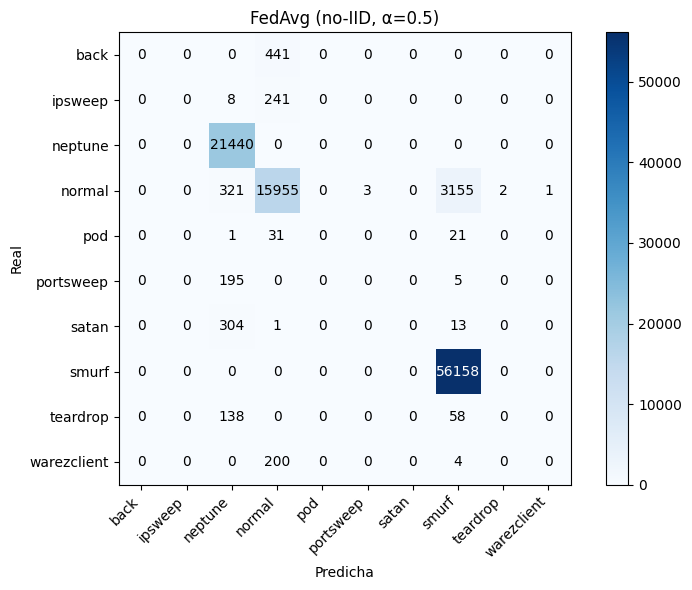

== FedAvg (no-IID, α=0.5): Matriz de confusión (Top-10) — NORMALIZADA ==


== FedAdam (no-IID, α=0.5): Matriz de confusión (Top-10) — ABSOLUTA ==


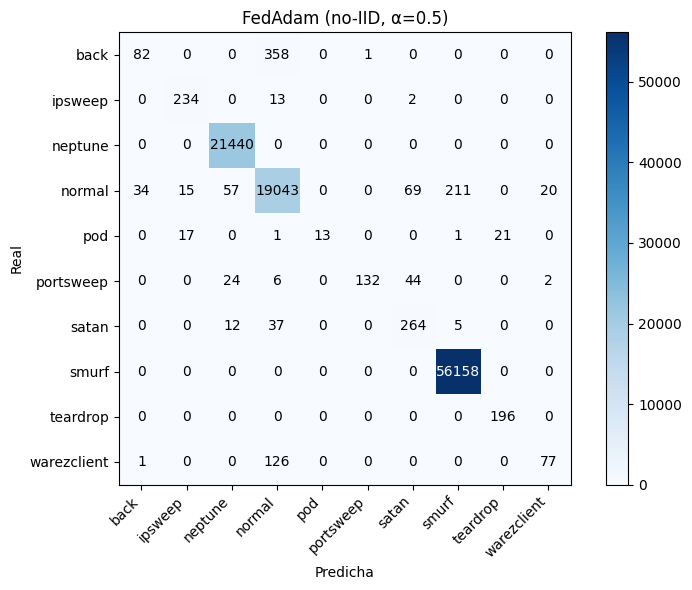

== FedAdam (no-IID, α=0.5): Matriz de confusión (Top-10) — NORMALIZADA ==


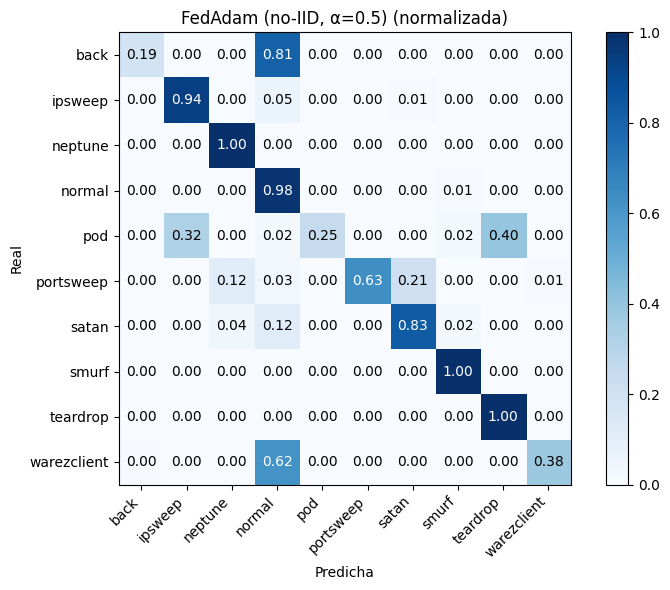

== FedProx (no-IID, α=0.5): Matriz de confusión (Top-10) — ABSOLUTA ==


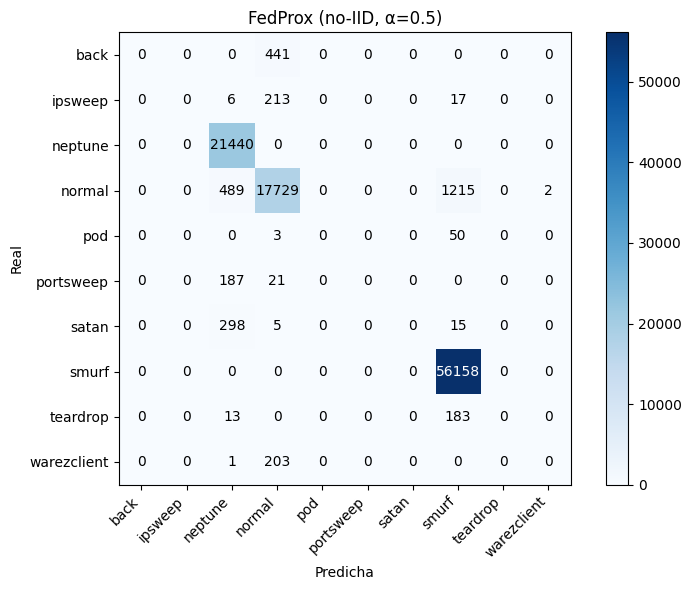

== FedProx (no-IID, α=0.5): Matriz de confusión (Top-10) — NORMALIZADA ==


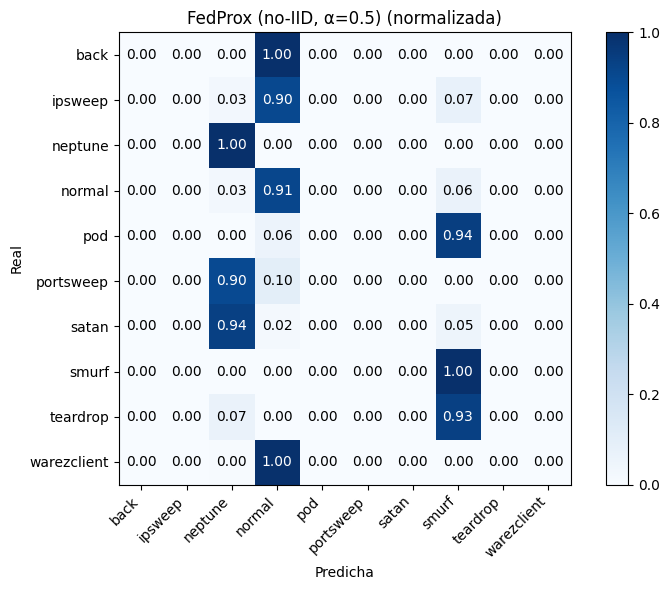

In [31]:
# === 5.4.3-vis · Matrices de confusión (no-IID, α=0.5): ABS y NORMALIZADA (Top-10 clases) ===
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
idx_to_class = {i: c for c, i in class_to_idx.items()}

def predict_labels(model):
    model = model.to(device).eval()
    with torch.no_grad():
        y_pred_idx = model(X_test_t.to(device)).argmax(1).cpu().numpy()
    y_true_idx = y_test_t.numpy()
    y_true_lab = np.array([idx_to_class[i] for i in y_true_idx])
    y_pred_lab = np.array([idx_to_class[i] for i in y_pred_idx])
    return y_true_lab, y_pred_lab

def plot_confusion_matrix_topk(y_true, y_pred, k=10, normalize=False, title="Confusión Top-10"):
    vc = pd.Series(y_true).value_counts()
    topk = vc.head(k).index.tolist()
    mask = pd.Series(y_true).isin(topk)
    yt, yp = pd.Series(y_true)[mask], pd.Series(y_pred)[mask]
    labels = sorted(topk)
    cm = confusion_matrix(yt, yp, labels=labels)
    if normalize:
        with np.errstate(all='ignore'):
            cm = cm / cm.sum(axis=1, keepdims=True)
            cm = np.nan_to_num(cm)
    fig, ax = plt.subplots(figsize=(8,6))
    im = ax.imshow(cm, cmap='Blues'); ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(labels)), yticks=np.arange(len(labels)),
           xticklabels=labels, yticklabels=labels,
           xlabel='Predicha', ylabel='Real',
           title=title + (' (normalizada)' if normalize else ''))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    fmt = '.2f' if normalize else 'd'; thr = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thr else 'black')
    plt.tight_layout(); plt.show()

models_noiid = [
    ("FedAvg (no-IID, α=0.5)",  globals().get("global_model_fedavg_noiid_a05")),
    ("FedAdam (no-IID, α=0.5)", globals().get("global_model_fedadam_noiid_a05")),
    ("FedProx (no-IID, α=0.5)", globals().get("global_model_fedprox_noiid_a05")),
]

for name, mdl in models_noiid:
    if mdl is None:
        continue
    y_true_lab, y_pred_lab = predict_labels(mdl)
    print(f"== {name}: Matriz de confusión (Top-10) — ABSOLUTA ==")
    plot_confusion_matrix_topk(y_true_lab, y_pred_lab, k=10, normalize=False, title=name)
    print(f"== {name}: Matriz de confusión (Top-10) — NORMALIZADA ==")
    plot_confusion_matrix_topk(y_true_lab, y_pred_lab, k=10, normalize=True,  title=name)


* no-IID (α=0.1): heterogeneidad extrema
Repetimos las **tres estrategias** con **α=0.1** para un reparto mucho más desigual entre clientes.


In [32]:
print("\n== FedAvg (no-IID, α=0.1) ==")
global_model_fedavg_noiid_a01, h_fedavg_noiid_a01 = run_federated(
    num_rounds=10, num_clients=10, frac_fit=0.5,
    iid=False, dir_alpha=0.1, local_epochs=1, lr=0.1,
    strategy_name="FedAvg", prox_mu=0.0
)
histories['FedAvg_noIID_a0.1'] = h_fedavg_noiid_a01

print("\n== FedAdam (no-IID, α=0.1) ==")
global_model_fedadam_noiid_a01, h_fedadam_noiid_a01 = run_federated(
    num_rounds=10, num_clients=10, frac_fit=0.5,
    iid=False, dir_alpha=0.1, local_epochs=1, lr=0.1,
    strategy_name="FedAdam", prox_mu=0.0
)
histories['FedAdam_noIID_a0.1'] = h_fedadam_noiid_a01

print("\n== FedProx (no-IID, α=0.1, μ=0.1) ==")
global_model_fedprox_noiid_a01, h_fedprox_noiid_a01 = run_federated(
    num_rounds=10, num_clients=10, frac_fit=0.5,
    iid=False, dir_alpha=0.1, local_epochs=1, lr=0.1,
    strategy_name="FedAvg", prox_mu=0.1
)
histories['FedProx_noIID_a0.1_mu0.1'] = h_fedprox_noiid_a01

print("Historial guardado:", list(histories.keys()))



== FedAvg (no-IID, α=0.1) ==
Ronda 01 | acc_test=0.9000 | acc_client_mean=0.8210
Ronda 02 | acc_test=0.5693 | acc_client_mean=0.8370
Ronda 03 | acc_test=0.5703 | acc_client_mean=0.8378
Ronda 04 | acc_test=0.7918 | acc_client_mean=0.9024
Ronda 05 | acc_test=0.8052 | acc_client_mean=0.8088
Ronda 06 | acc_test=0.8948 | acc_client_mean=0.8622
Ronda 07 | acc_test=0.8931 | acc_client_mean=0.8528
Ronda 08 | acc_test=0.8860 | acc_client_mean=0.9020
Ronda 09 | acc_test=0.8779 | acc_client_mean=0.9311
Ronda 10 | acc_test=0.8717 | acc_client_mean=0.9077

== FedAdam (no-IID, α=0.1) ==
Ronda 01 | acc_test=0.9826 | acc_client_mean=0.8086
Ronda 02 | acc_test=0.9807 | acc_client_mean=0.5104
Ronda 03 | acc_test=0.9819 | acc_client_mean=0.6730
Ronda 04 | acc_test=0.9820 | acc_client_mean=0.6802
Ronda 05 | acc_test=0.9819 | acc_client_mean=0.5661
Ronda 06 | acc_test=0.9838 | acc_client_mean=0.8284
Ronda 07 | acc_test=0.9850 | acc_client_mean=0.7946
Ronda 08 | acc_test=0.9839 | acc_client_mean=0.9214
Ron

In [33]:
def metrics_for_model(model):
    model = model.to(device).eval()
    with torch.no_grad():
        y_pred_idx = model(X_test_t.to(device)).argmax(1).cpu().numpy()
    y_true_idx = y_test_t.numpy()
    return dict(
        accuracy           = accuracy_score(y_true_idx, y_pred_idx),
        precision_macro    = precision_score(y_true_idx, y_pred_idx, average="macro",    zero_division=0),
        precision_weighted = precision_score(y_true_idx, y_pred_idx, average="weighted", zero_division=0),
        recall_macro       = recall_score(  y_true_idx, y_pred_idx, average="macro",     zero_division=0),
        recall_weighted    = recall_score(  y_true_idx, y_pred_idx, average="weighted",  zero_division=0),
        f1_macro           = f1_score(      y_true_idx, y_pred_idx, average="macro",     zero_division=0),
        f1_weighted        = f1_score(      y_true_idx, y_pred_idx, average="weighted",  zero_division=0),
    )

rows = [
    {"estrategia":"FedAvg_noIID_a0.1",  **metrics_for_model(global_model_fedavg_noiid_a01)},
    {"estrategia":"FedAdam_noIID_a0.1", **metrics_for_model(global_model_fedadam_noiid_a01)},
    {"estrategia":"FedProx_noIID_a0.1", **metrics_for_model(global_model_fedprox_noiid_a01)},
]
metrics_noiid_a01 = pd.DataFrame(rows).set_index("estrategia").round(4)
display(metrics_noiid_a01)


accuracy  precision_macro  precision_weighted  \
estrategia                                                          
FedAvg_noIID_a0.1     0.8717           0.1417              0.8726   
FedAdam_noIID_a0.1    0.9260           0.5449              0.9687   
FedProx_noIID_a0.1    0.8157           0.1274              0.8235   

                    recall_macro  recall_weighted  f1_macro  f1_weighted  
estrategia                                                                
FedAvg_noIID_a0.1         0.1495           0.8717    0.1374       0.8488  
FedAdam_noIID_a0.1        0.4770           0.9260    0.4519       0.9416  
FedProx_noIID_a0.1        0.1283           0.8157    0.1095       0.7590

== FedAvg (no-IID, α=0.1): Matriz de confusión (Top-10) — ABSOLUTA ==


== FedAvg (no-IID, α=0.1): Matriz de confusión (Top-10) — NORMALIZADA ==


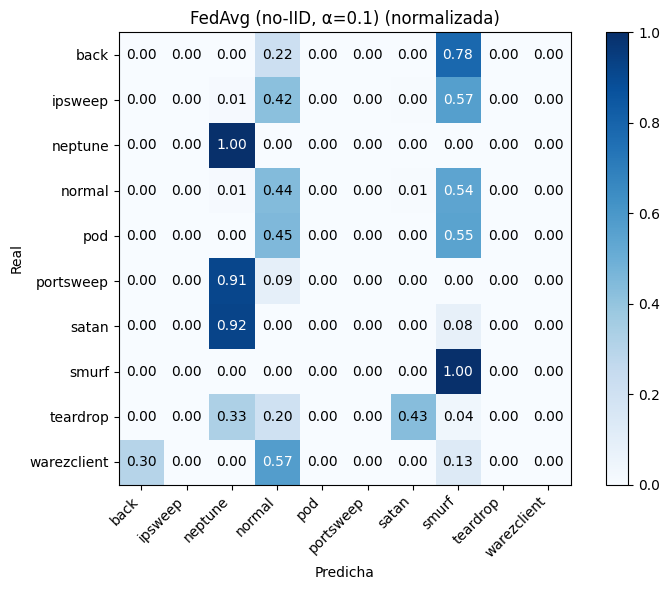

== FedAdam (no-IID, α=0.1): Matriz de confusión (Top-10) — ABSOLUTA ==


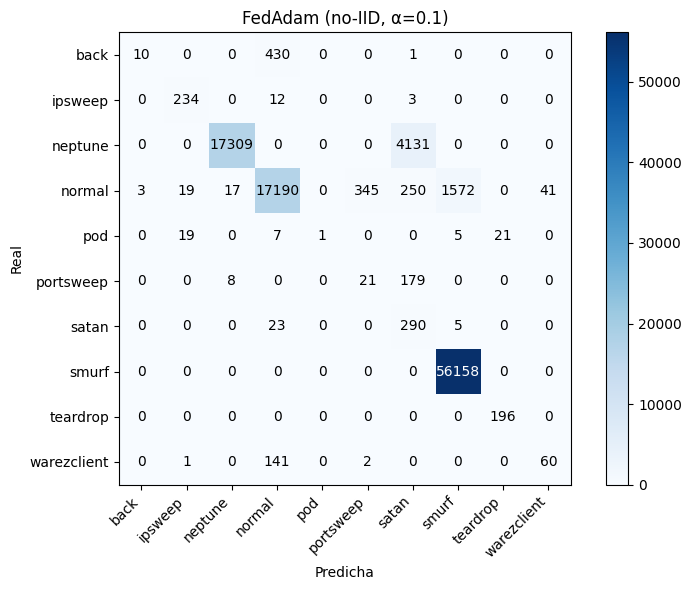

== FedAdam (no-IID, α=0.1): Matriz de confusión (Top-10) — NORMALIZADA ==


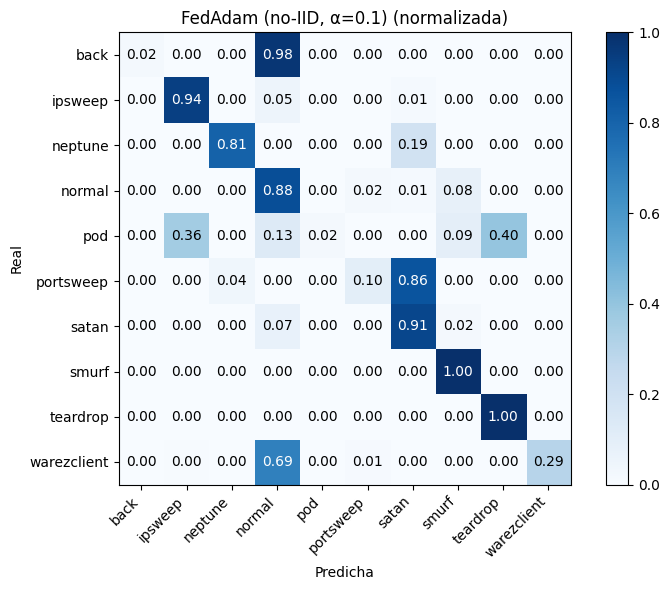

== FedProx (no-IID, α=0.1): Matriz de confusión (Top-10) — ABSOLUTA ==


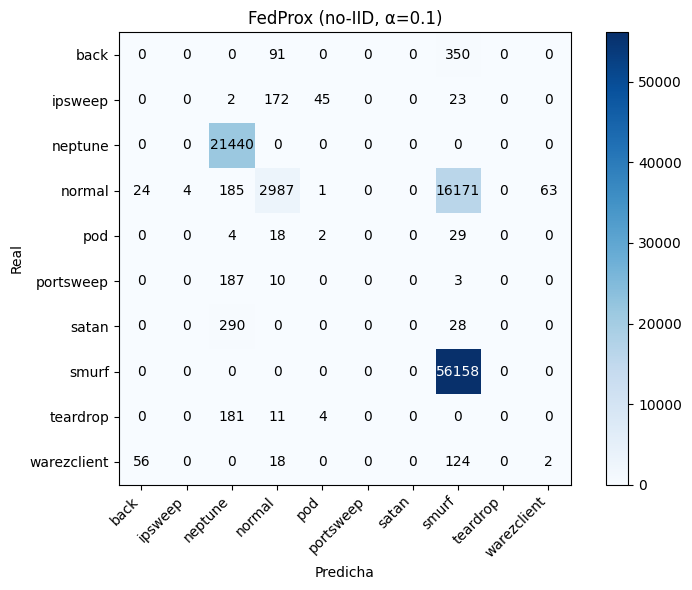

== FedProx (no-IID, α=0.1): Matriz de confusión (Top-10) — NORMALIZADA ==


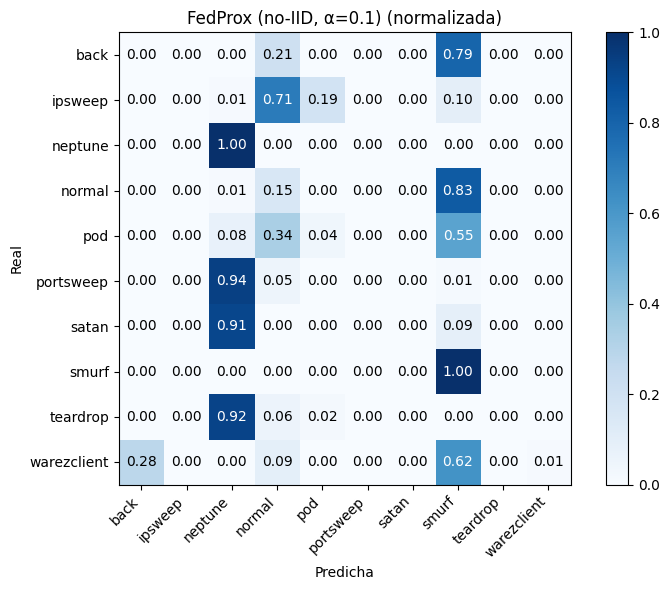

In [34]:
idx_to_class = {i: c for c, i in class_to_idx.items()}

def predict_labels(model):
    model = model.to(device).eval()
    with torch.no_grad():
        y_pred_idx = model(X_test_t.to(device)).argmax(1).cpu().numpy()
    y_true_idx = y_test_t.numpy()
    y_true_lab = np.array([idx_to_class[i] for i in y_true_idx])
    y_pred_lab = np.array([idx_to_class[i] for i in y_pred_idx])
    return y_true_lab, y_pred_lab

def plot_confusion_matrix_topk(y_true, y_pred, k=10, normalize=False, title="Confusión Top-10"):
    vc = pd.Series(y_true).value_counts()
    topk = vc.head(k).index.tolist()
    mask = pd.Series(y_true).isin(topk)
    yt, yp = pd.Series(y_true)[mask], pd.Series(y_pred)[mask]
    labels = sorted(topk)
    cm = confusion_matrix(yt, yp, labels=labels)
    if normalize:
        with np.errstate(all='ignore'):
            cm = cm / cm.sum(axis=1, keepdims=True)
            cm = np.nan_to_num(cm)
    fig, ax = plt.subplots(figsize=(8,6))
    im = ax.imshow(cm, cmap='Blues'); ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(labels)), yticks=np.arange(len(labels)),
           xticklabels=labels, yticklabels=labels,
           xlabel='Predicha', ylabel='Real',
           title=title + (' (normalizada)' if normalize else ''))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    fmt = '.2f' if normalize else 'd'; thr = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thr else 'black')
    plt.tight_layout(); plt.show()

models_noiid_a01 = [
    ("FedAvg (no-IID, α=0.1)",  global_model_fedavg_noiid_a01),
    ("FedAdam (no-IID, α=0.1)", global_model_fedadam_noiid_a01),
    ("FedProx (no-IID, α=0.1)", global_model_fedprox_noiid_a01),
]

for name, mdl in models_noiid_a01:
    y_true_lab, y_pred_lab = predict_labels(mdl)
    print(f"== {name}: Matriz de confusión (Top-10) — ABSOLUTA ==")
    plot_confusion_matrix_topk(y_true_lab, y_pred_lab, k=10, normalize=False, title=name)
    print(f"== {name}: Matriz de confusión (Top-10) — NORMALIZADA ==")
    plot_confusion_matrix_topk(y_true_lab, y_pred_lab, k=10, normalize=True,  title=name)


##### 5.4.4 · Curvas de rendimiento federado y comparación con el baseline centralizado

Graficamos la **accuracy** global por ronda de cada estrategia y trazamos el **baseline centralizado** (LogReg) como línea discontinua.


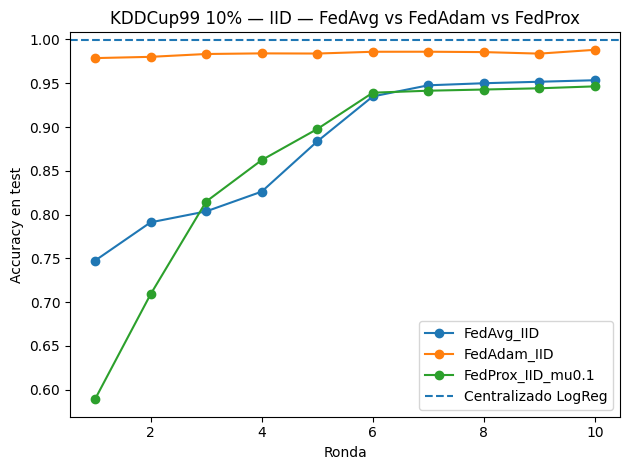

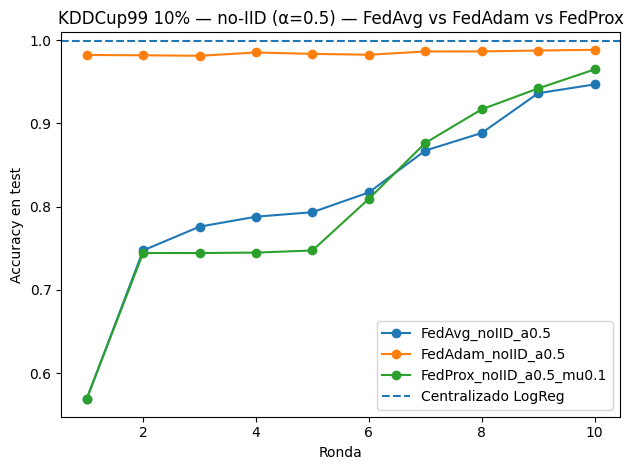

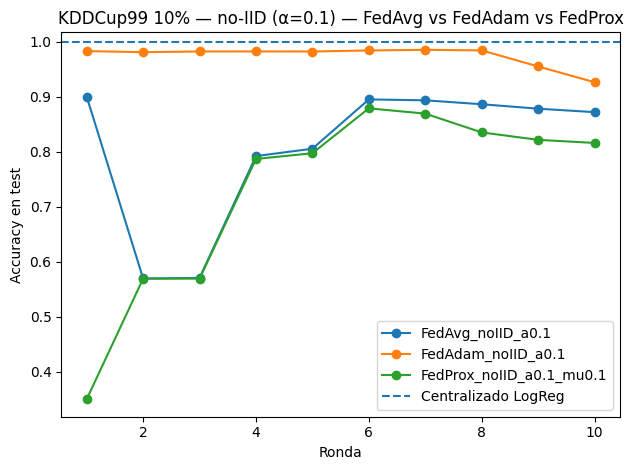

In [35]:
# 1) Línea base centralizada (LogReg)
baseline_acc = None
try:
    baseline_acc = float(central_kdd_results.loc['LogReg', 'acc'])
except Exception:
    try:
        baseline_acc = float(central_kdd_results['LogReg']['acc'])
    except Exception:
        pass

# 2) Grupos de ejecuciones
groups = [
    ("IID — FedAvg vs FedAdam vs FedProx",
     ['FedAvg_IID', 'FedAdam_IID', 'FedProx_IID_mu0.1']),
    ("no-IID (α=0.5) — FedAvg vs FedAdam vs FedProx",
     ['FedAvg_noIID_a0.5', 'FedAdam_noIID_a0.5', 'FedProx_noIID_a0.5_mu0.1']),
    ("no-IID (α=0.1) — FedAvg vs FedAdam vs FedProx",
     ['FedAvg_noIID_a0.1', 'FedAdam_noIID_a0.1', 'FedProx_noIID_a0.1_mu0.1']),
]

# 3) Pintar cada grupo en su propia figura
for title, keys in groups:
    plt.figure()
    any_plotted = False
    for k in keys:
        if k in histories:
            h = histories[k]
            plt.plot(h['round'], h['acc_global'], marker='o', label=k)
            any_plotted = True
    if baseline_acc is not None:
        plt.axhline(baseline_acc, linestyle='--', label='Centralizado LogReg')
    plt.xlabel("Ronda")
    plt.ylabel("Accuracy en test")
    plt.title(f"KDDCup99 10% — {title}")
    if any_plotted or baseline_acc is not None:
        plt.legend()
    plt.tight_layout()
    plt.show()


# 6. Federated Learning con MNIST (CNN)

Usaremos la **CNN** de la sección centralizada, pero ahora en **federado**.  
Flujo general:
1) **Particionar** el dataset de entrenamiento entre **N** clientes (IID o no-IID).  
2) Cada cliente **entrena localmente** la CNN con sus datos.  
3) El servidor **agrega** las actualizaciones (estrategia: FedAvg, FedAdam o FedProx).  
4) **Evaluamos** el modelo global tras cada ronda.


#### 6.1 · Particionado de clientes (IID / no-IID)

- **IID**: reparto aleatorio uniforme de índices.  
- **no-IID (Dirichlet α)**: cada cliente recibe porcentajes distintos por clase (cuanto menor α, mayor heterogeneidad).


In [39]:
from torch.utils.data import DataLoader, Subset

# Tomamos etiquetas del dataset de entrenamiento de MNIST ya cargado
y_train_mnist = train_mnist.dataset.targets  # tensor de etiquetas (0..9)

def mnist_clients_iid(num_clients=10, batch_size=128, seed=1234):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(train_mnist.dataset))
    rng.shuffle(idx)
    splits = np.array_split(idx, num_clients)
    loaders = []
    for sp in splits:
        subset = Subset(train_mnist.dataset, sp.tolist())
        loaders.append(DataLoader(subset, batch_size=batch_size, shuffle=True))
    return loaders

def mnist_clients_dirichlet(num_clients=10, alpha=0.3, batch_size=128, seed=1234):
    rng = np.random.default_rng(seed)
    y = y_train_mnist.numpy()
    idx_by_class = {c: np.where(y==c)[0] for c in np.unique(y)}
    for c in idx_by_class: rng.shuffle(idx_by_class[c])
    client_indices = [[] for _ in range(num_clients)]
    for c, idxs in idx_by_class.items():
        proportions = rng.dirichlet([alpha]*num_clients)
        counts = (proportions * len(idxs)).astype(int)
        while counts.sum() < len(idxs): counts[rng.integers(0,num_clients)] += 1
        start=0
        for cid, cnt in enumerate(counts):
            client_indices[cid].extend(idxs[start:start+cnt]); start += cnt
    loaders = []
    for inds in client_indices:
        subset = Subset(train_mnist.dataset, sorted(inds))
        loaders.append(DataLoader(subset, batch_size=batch_size, shuffle=True))
    return loaders


#### 6.2 · Entrenamiento local y evaluación

Cada cliente entrena **pocas épocas** con **Adam** y `CrossEntropyLoss`.  
La evaluación global calcula la **accuracy** en `test_mnist`.


In [42]:
import torch, torch.nn as nn, torch.optim as optim
from copy import deepcopy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def _make_opt_and_crit(model, lr=1e-3):
    """Crea optimizer y criterion estándar para la CNN local."""
    opt = optim.Adam(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()
    return opt, crit

def train_local_cnn(model, loader, epochs=1, lr=1e-3, prox_mu=0.0, global_params=None):
    """
    Adaptador para entrenamiento local:
      - Si prox_mu == 0: reutiliza 'train_epoch'.
      - Si prox_mu  > 0: añade el término proximal (FedProx).
    Devuelve el 'state_dict' del modelo local tras entrenar.
    """
    model = model.to(device)
    opt, criterion = _make_opt_and_crit(model, lr=lr)

    if prox_mu <= 0.0:
        # Caso estándar (FedAvg / FedAdam): reutiliza directamente train_epoch
        for _ in range(epochs):
            _ = train_epoch(model, loader, criterion, opt)  # función ya definida 
        return deepcopy(model.state_dict())

    # Caso FedProx: mismo bucle que train_epoch, pero con término proximal ||w - w_global||^2
    assert global_params is not None, "Se requieren 'global_params' cuando prox_mu > 0 (FedProx)."
    model.train()
    for _ in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            # Término proximal: penaliza la distancia a los pesos globales
            prox_term = 0.0
            for p, w0 in zip(model.parameters(), global_params):
                prox_term = prox_term + ((p - w0.to(device))**2).sum()
            loss = loss + (prox_mu / 2.0) * prox_term
            loss.backward()
            opt.step()

    return deepcopy(model.state_dict())

def evaluate_cnn(model):
    """Alias explícito para reutilizar eval_acc de 4.2 sobre test_mnist."""
    return eval_acc(model, test_mnist)  # eval_acc ya definida


#### 6.3 · Estrategias y bucle federado

- **FedAvg**: promedio simple de parámetros locales (ponderado por nº de muestras).  
- **FedAdam**: optimizador **Adam** en el servidor (aplica una “actualización” tipo Adam sobre el promedio local).  
- **FedProx**: el promedio es como FedAvg, pero el **entrenamiento local** penaliza alejarse del modelo global (μ > 0).


In [43]:
class ServerAdam:
    """Adam en el servidor: mantiene m y v por parámetro y aplica actualización Adam sobre el promedio local."""
    def __init__(self, params_like, lr=0.1, betas=(0.9,0.999), eps=1e-8):
        self.lr, self.betas, self.eps = lr, betas, eps
        self.m = {k: torch.zeros_like(v) for k,v in params_like.items()}
        self.v = {k: torch.zeros_like(v) for k,v in params_like.items()}
        self.t = 0

    def step(self, global_state, avg_state):
        self.t += 1
        b1, b2 = self.betas
        new_state = {}
        for k in global_state:
            # "gradiente" de servidor ~ diferencia entre promedio local y estado global
            g = avg_state[k] - global_state[k]
            self.m[k] = b1*self.m[k] + (1-b1)*g
            self.v[k] = b2*self.v[k] + (1-b2)*(g*g)
            mhat = self.m[k]/(1 - b1**self.t)
            vhat = self.v[k]/(1 - b2**self.t)
            new_state[k] = global_state[k] + self.lr * mhat / (torch.sqrt(vhat) + self.eps)
        return new_state

def run_federated_mnist(strategy="FedAvg", num_rounds=3, num_clients=10, frac_fit=0.5, local_epochs=1, prox_mu=0.0, alpha=None, batch_size=128, seed=1234):
    """
    strategy in {"FedAvg","FedAdam","FedProx"}.
    - alpha=None -> IID ; alpha=0.3 (por ejemplo) -> no-IID Dirichlet.
    - prox_mu > 0 solo tiene efecto en FedProx (término proximal local).
    """
    # 1) Clientes
    if alpha is None:
        clients = mnist_clients_iid(num_clients=num_clients, batch_size=batch_size, seed=seed)
    else:
        clients = mnist_clients_dirichlet(num_clients=num_clients, alpha=alpha, batch_size=batch_size, seed=seed)

    # 2) Modelo global y (si procede) estado de Adam del servidor
    global_model = SimpleCNN().to(device)
    server_adam = ServerAdam(global_model.state_dict()) if strategy=="FedAdam" else None

    hist = {'round':[], 'acc_global':[]}
    for rnd in range(1, num_rounds+1):
        # 3) Selección de subset de clientes
        m = max(1, int(frac_fit * num_clients))
        selected = np.random.default_rng(seed + rnd).choice(np.arange(num_clients), size=m, replace=False)

        # 4) Entrenamiento local y recolección de estados
        updates = []
        global_params = [p.detach().clone() for p in global_model.parameters()]
        for cid in selected:
            local = SimpleCNN().to(device)
            local.load_state_dict({k:v.clone() for k,v in global_model.state_dict().items()})
            sd = train_local_cnn(local, clients[cid], epochs=local_epochs, lr=1e-3,
                                 prox_mu=(prox_mu if strategy=="FedProx" else 0.0),
                                 global_params=(global_params if strategy=="FedProx" else None))
            updates.append((sd, len(clients[cid].dataset)))

        # 5) Agregación (promedio ponderado) y/o paso Adam del servidor
        total = sum(n for _,n in updates)
        avg_state = {k: torch.zeros_like(v) for k,v in global_model.state_dict().items()}
        for sd, n in updates:
            w = n/total
            for k in avg_state: avg_state[k] += sd[k]*w

        if strategy == "FedAdam":
            new_state = server_adam.step(global_model.state_dict(), avg_state)
        else:
            new_state = avg_state  # FedAvg / FedProx: usar promedio directo

        global_model.load_state_dict(new_state)

        # 6) Evaluación global
        acc = eval_acc(global_model, test_mnist)
        hist['round'].append(rnd); hist['acc_global'].append(acc)
        print(f"[{strategy}] Ronda {rnd}: acc_test={acc:.4f}")

    return global_model, hist


#### 6.4 · Experimento IID (α = None): FedAvg vs FedAdam vs FedProx

Probamos 3 estrategias con **IID**, pocas rondas para el taller.  
Guardamos el **histórico de accuracy** para graficar y los **modelos finales** para evaluar métricas completas.


[FedAvg] Ronda 1: acc_test=0.7970
[FedAvg] Ronda 2: acc_test=0.9197
[FedAvg] Ronda 3: acc_test=0.9434
[FedAvg] Ronda 4: acc_test=0.9601
[FedAvg] Ronda 5: acc_test=0.9671
[FedAvg] Ronda 6: acc_test=0.9733
[FedAvg] Ronda 7: acc_test=0.9747
[FedAvg] Ronda 8: acc_test=0.9766
[FedAvg] Ronda 9: acc_test=0.9794
[FedAvg] Ronda 10: acc_test=0.9820
[FedAdam] Ronda 1: acc_test=0.6898
[FedAdam] Ronda 2: acc_test=0.3570
[FedAdam] Ronda 3: acc_test=0.3818
[FedAdam] Ronda 4: acc_test=0.2296
[FedAdam] Ronda 5: acc_test=0.5082
[FedAdam] Ronda 6: acc_test=0.5663
[FedAdam] Ronda 7: acc_test=0.6904
[FedAdam] Ronda 8: acc_test=0.5103
[FedAdam] Ronda 9: acc_test=0.8677
[FedAdam] Ronda 10: acc_test=0.8328
[FedProx] Ronda 1: acc_test=0.8199
[FedProx] Ronda 2: acc_test=0.9208
[FedProx] Ronda 3: acc_test=0.9402
[FedProx] Ronda 4: acc_test=0.9542
[FedProx] Ronda 5: acc_test=0.9628
[FedProx] Ronda 6: acc_test=0.9689
[FedProx] Ronda 7: acc_test=0.9728
[FedProx] Ronda 8: acc_test=0.9761
[FedProx] Ronda 9: acc_test=

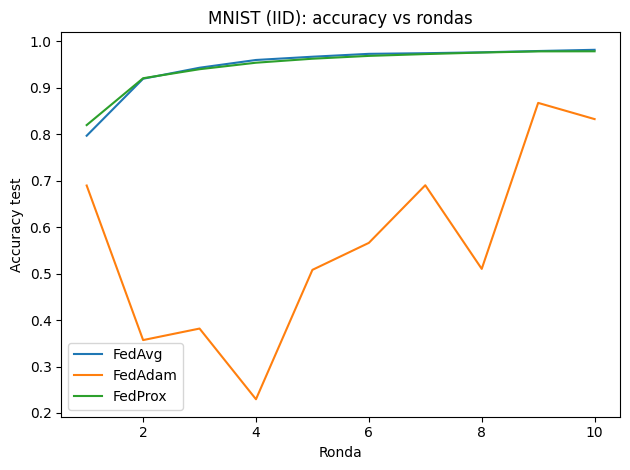

In [45]:
# Ejecuta con parámetros modestos para mantener tiempos cortos en aula
models_iid = {}
hists_iid  = {}

for strat, kwargs in [
    ("FedAvg",  dict(prox_mu=0.0)),
    ("FedAdam", dict(prox_mu=0.0)),
    ("FedProx", dict(prox_mu=0.1)),  # μ pequeño para penalización suave
]:
    m, h = run_federated_mnist(strategy=strat, num_rounds=10, num_clients=10, frac_fit=0.5, local_epochs=1, alpha=None)
    models_iid[strat] = m
    hists_iid[strat]  = h

# Curvas de accuracy por ronda
import matplotlib.pyplot as plt
plt.figure()
for name, h in hists_iid.items():
    plt.plot(h['round'], h['acc_global'], label=name)
plt.xlabel("Ronda"); plt.ylabel("Accuracy test"); plt.title("MNIST (IID): accuracy vs rondas")
plt.legend(); plt.tight_layout(); plt.show()


#### 6.5 · Métricas de rendimiento (IID)

Calculamos **accuracy**, **precision/recall (macro y weighted)** y **F1 (macro y weighted)** para cada estrategia.


accuracy  precision_macro  precision_weighted  recall_macro  \
FedAvg     0.9820           0.9821              0.9820        0.9819   
FedAdam    0.8328           0.8675              0.8668        0.8292   
FedProx    0.9788           0.9788              0.9789        0.9788   

         recall_weighted  f1_macro  f1_weighted  
FedAvg            0.9820    0.9820       0.9820  
FedAdam           0.8328    0.8307       0.8327  
FedProx           0.9788    0.9788       0.9788

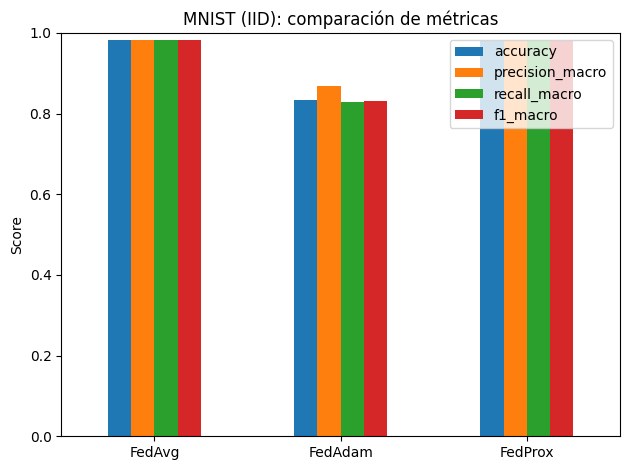

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def eval_full_metrics(model):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in test_mnist:
            xb = xb.to(device)
            y_true.extend(yb.numpy())
            y_pred.extend(model(xb).argmax(1).cpu().numpy())
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return {
        'accuracy':           accuracy_score(y_true, y_pred),
        'precision_macro':    precision_score(y_true, y_pred, average='macro',    zero_division=0),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall_macro':       recall_score(  y_true, y_pred, average='macro',     zero_division=0),
        'recall_weighted':    recall_score(  y_true, y_pred, average='weighted',  zero_division=0),
        'f1_macro':           f1_score(      y_true, y_pred, average='macro',     zero_division=0),
        'f1_weighted':        f1_score(      y_true, y_pred, average='weighted',  zero_division=0),
        'report_df':          pd.DataFrame(classification_report(y_true, y_pred, output_dict=True, zero_division=0)).T
    }

scores_iid = {}
for name, model in models_iid.items():
    scores_iid[name] = eval_full_metrics(model)

# Tabla comparativa
df_iid = pd.DataFrame({k: {m: round(v[m],4) for m in ['accuracy','precision_macro','precision_weighted','recall_macro','recall_weighted','f1_macro','f1_weighted']} 
                       for k,v in scores_iid.items()}).T
display(df_iid)

# Gráfico comparativo
ax = df_iid[['accuracy','precision_macro','recall_macro','f1_macro']].plot(kind='bar', rot=0, title='MNIST (IID): comparación de métricas')
ax.set_ylim(0,1.0); ax.set_ylabel('Score'); plt.tight_layout(); plt.show()


#### 6.6 · Matrices de confusión (IID)

Mostramos la **matriz 10×10** para cada estrategia (versión normalizada por fila).


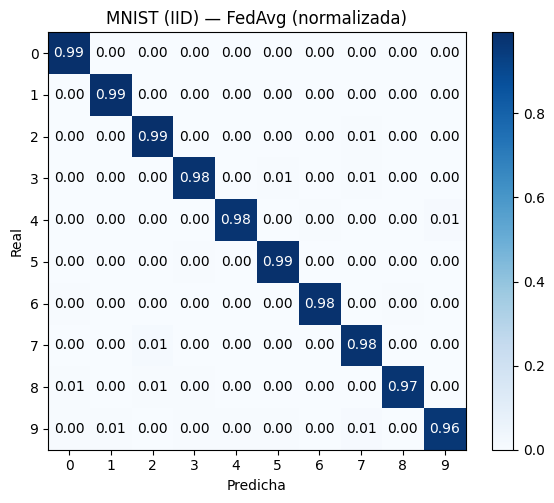

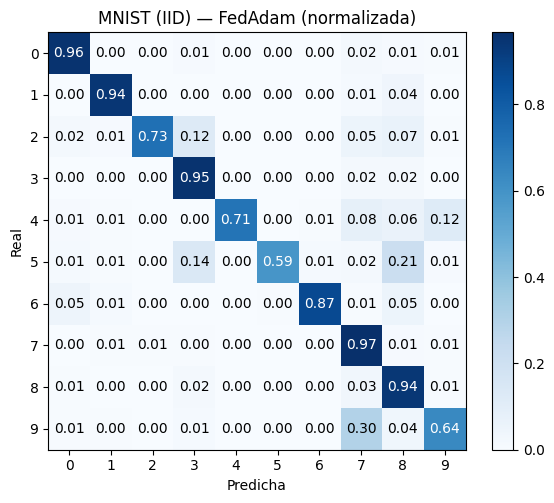

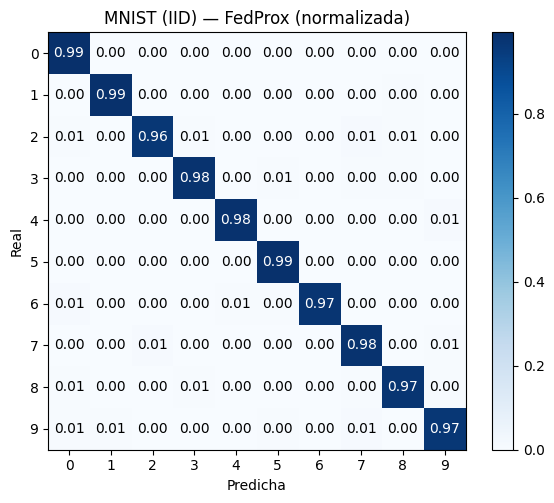

In [47]:

def plot_cm(model, title):
    # Recolectar predicciones
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in test_mnist:
            xb = xb.to(device)
            y_true.extend(yb.numpy())
            y_pred.extend(model(xb).argmax(1).cpu().numpy())
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    labels = list(range(10))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cmn = cm / cm.sum(axis=1, keepdims=True)
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(cmn, cmap='Blues'); ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(10), yticks=np.arange(10),
           xticklabels=labels, yticklabels=labels,
           xlabel='Predicha', ylabel='Real', title=title+' (normalizada)')
    th = np.nanmax(cmn)/2
    for i in range(10):
        for j in range(10):
            val = cmn[i,j]
            if np.isnan(val): val = 0.0
            ax.text(j, i, f"{val:.2f}", ha='center', va='center',
                    color='white' if val > th else 'black')
    plt.tight_layout(); plt.show()

for name, model in models_iid.items():
    plot_cm(model, f"MNIST (IID) — {name}")


#### 6.7 · Experimento no-IID (α = 0.3): FedAvg vs FedAdam vs FedProx

Repetimos el experimento pero con **no-IID** (Dirichlet α=0.3).  
Con no-IID, **FedProx** puede ayudar a estabilizar el entrenamiento.


[FedAvg] Ronda 1: acc_test=0.3203
[FedAvg] Ronda 2: acc_test=0.5948
[FedAvg] Ronda 3: acc_test=0.7756
[FedAvg] Ronda 4: acc_test=0.8648
[FedAvg] Ronda 5: acc_test=0.9064
[FedAvg] Ronda 6: acc_test=0.9322
[FedAvg] Ronda 7: acc_test=0.9403
[FedAvg] Ronda 8: acc_test=0.9516
[FedAvg] Ronda 9: acc_test=0.9568
[FedAvg] Ronda 10: acc_test=0.9667
[FedAdam] Ronda 1: acc_test=0.2206
[FedAdam] Ronda 2: acc_test=0.2707
[FedAdam] Ronda 3: acc_test=0.1341
[FedAdam] Ronda 4: acc_test=0.2413
[FedAdam] Ronda 5: acc_test=0.4704
[FedAdam] Ronda 6: acc_test=0.3348
[FedAdam] Ronda 7: acc_test=0.4661
[FedAdam] Ronda 8: acc_test=0.5627
[FedAdam] Ronda 9: acc_test=0.5863
[FedAdam] Ronda 10: acc_test=0.5179
[FedProx] Ronda 1: acc_test=0.4597
[FedProx] Ronda 2: acc_test=0.6810
[FedProx] Ronda 3: acc_test=0.8350
[FedProx] Ronda 4: acc_test=0.8886
[FedProx] Ronda 5: acc_test=0.9111
[FedProx] Ronda 6: acc_test=0.9329
[FedProx] Ronda 7: acc_test=0.9478
[FedProx] Ronda 8: acc_test=0.9572
[FedProx] Ronda 9: acc_test=

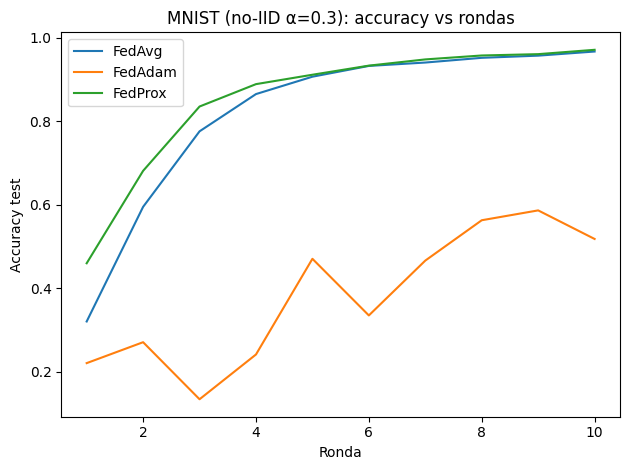

In [49]:
models_niid = {}
hists_niid  = {}

for strat, kwargs in [
    ("FedAvg",  dict(prox_mu=0.0)),
    ("FedAdam", dict(prox_mu=0.0)),
    ("FedProx", dict(prox_mu=0.1)),
]:
    m, h = run_federated_mnist(strategy=strat, num_rounds=10, num_clients=10, frac_fit=0.5, local_epochs=1, alpha=0.3)
    models_niid[strat] = m
    hists_niid[strat]  = h

plt.figure()
for name, h in hists_niid.items():
    plt.plot(h['round'], h['acc_global'], label=name)
plt.xlabel("Ronda"); plt.ylabel("Accuracy test"); plt.title("MNIST (no-IID α=0.3): accuracy vs rondas")
plt.legend(); plt.tight_layout(); plt.show()


#### 6.8 · Métricas (no-IID)


In [50]:
scores_niid = {}
for name, model in models_niid.items():
    scores_niid[name] = eval_full_metrics(model)

df_niid = pd.DataFrame({k: {m: round(v[m],4) for m in ['accuracy','precision_macro','precision_weighted','recall_macro','recall_weighted','f1_macro','f1_weighted']} 
                       for k,v in scores_niid.items()}).T
display(df_niid)

ax = df_niid[['accuracy','precision_macro','recall_macro','f1_macro']].plot(kind='bar', rot=0, title='MNIST (no-IID α=0.3): comparación de métricas')
ax.set_ylim(0,1.0); ax.set_ylabel('Score'); plt.tight_layout(); plt.show()


accuracy  precision_macro  precision_weighted  recall_macro  \
FedAvg     0.9667           0.9676              0.9678        0.9669   
FedAdam    0.5179           0.7557              0.7600        0.5237   
FedProx    0.9708           0.9714              0.9716        0.9710   

         recall_weighted  f1_macro  f1_weighted  
FedAvg            0.9667    0.9668       0.9668  
FedAdam           0.5179    0.5231       0.5202  
FedProx           0.9708    0.9708       0.9708

#### 6.9 · Matrices de confusión (no-IID)


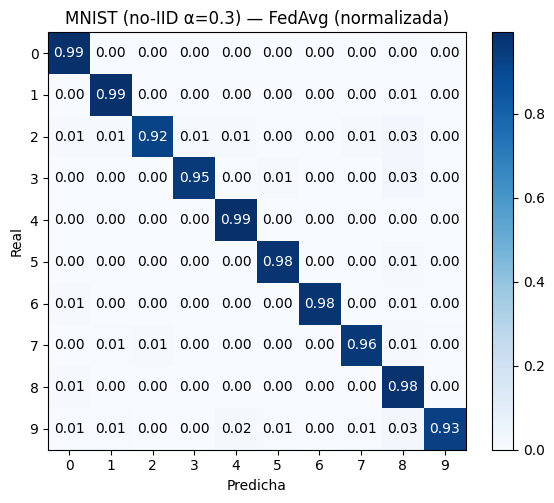

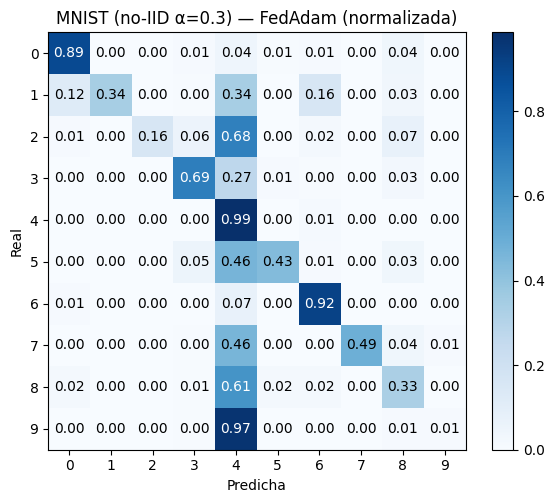

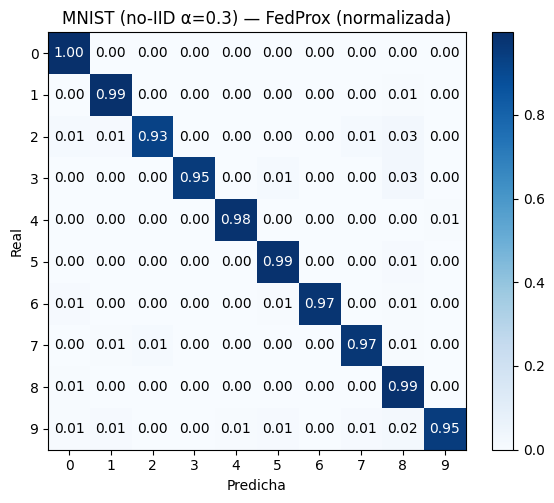

In [51]:
for name, model in models_niid.items():
    plot_cm(model, f"MNIST (no-IID α=0.3) — {name}")


<a id="avanzado"></a>
## 7. Experimentos avanzados (opcional)

- **Stragglers / *dropout***: simule clientes lentos u omitidos variando `frac_fit` y el conjunto de clientes seleccionados por ronda.
- **Robustez**: reemplace la agregación por la **mediana** por peso (o recorte) ante *outliers*. (*Ejercicio sugerido* en la sección 8).
- **Privacidad diferencial**: integre **Opacus** para aplicar **DP-SGD** en el entrenamiento local (clipping + ruido). *Afecta al trade-off privacidad-precisión*.
- **Early stopping**: detenga rondas si no mejora la métrica global (monitoring del `hist`).



<a id="ejercicios"></a>
## 8. Ejercicios guiados y retos

1. **No-IID extremo**: repita KDD con \(\alpha=0.05\) y compare FedAvg vs FedProx (distintos `prox_mu`). ¿Qué combinación estabiliza mejor la convergencia?
2. **Robustez a outliers**: implemente una agregación por **mediana** de parámetros y compárela con el promedio clásico ante un cliente malicioso que envía pesos escalados.
3. **Budget de comunicación**: mida el tamaño de las actualizaciones (nº de parámetros) y estime MB/ronda. Proponga una política de `num_rounds` vs `local_epochs` para un presupuesto fijo.
4. **MNIST con no-IID**: fuerce que cada cliente vea solo 2 dígitos. ¿Cómo varía la precisión global frente al caso IID?
5. **DP-SGD local** (opcional): integre Opacus en `train_local` y explore el impacto del ruido en accuracy.

> Añada sus conclusiones en celdas Markdown al final de cada ejercicio.


<a id="buenas_practicas"></a>
## 9. Buenas prácticas, reproducibilidad y referencias

- Fije **semillas aleatorias** (`numpy`, `torch`) y registre versiones de librerías.
- Controle **tiempos** y recursos: `num_rounds`, `frac_fit`, `local_epochs`.
- Documente supuestos de particionado y clases mayoritarias/minoritarias en KDD.
- Use *pipelines* (scikit-learn) y **modelos modulares** (PyTorch).
- Para reproducibilidad total, congele un **fichero `requirements.txt`** o un **`environment.yml`**.

**Referencias** seleccionadas
- McMahan et al., 2017 (*Communication-Efficient Learning of Deep Networks from Decentralized Data*).
- Li et al., 2020 (*Federated Optimization in Heterogeneous Networks*, FedProx).
- Flower: documentación oficial (API de estrategia/cliente/servidor) y *Flower Simulation*.
